In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install nba_api
import nba_api

## Introduction

Statistics and Data Science are a key part of sports analytics. Knowledge extracted from statistical models and machine learning can be applied to many contexts within basketball. It can help fuel strategies and decisions within a team, drive discussion within sports media and journalism, and is a essential for sports gambling companies such as Prize Picks. 

My goal with this project is to leverage a statistical model that can effectively predict LeBron's points on a given night and give insight into the factors that contribute to his performance. 

#### How can we use Statistics and Machine Learning ?
Recall a  Statistical Model can be expressed as:
$$
\begin{aligned}
Y_i &= f(\bold{x_i}) + \epsilon_i \\
\end{aligned}
$$

where in our case,
- $Y_i$ is LeBron's Points on the ith game of a season
- $\bold{x_i}$ is a vector of data available going into the ith game of season
- $f(\bold{x_i})$ is a function that describes the true inherit connection between our data and our statistic of interest: LeBron's points.
- $\epsilon_i$ contains all the randomness that cannot be captured or foreseen in $f(\bold{x_i})$
  
We can then use this model to estimate LeBron's points: 

$$
\hat{Y_i} = \widehat{f(\bold{x_i})}
$$

where:
- $\hat{Y_i}$ is the model's prediction for LeBron's points on the ith game
- $\widehat{f(\bold{x_i})}$ is our estimate of the function $f(\bold{x_i})$


#### How can we tell if our model works? 
We can quantify the accuracy of our model using a metric such as Mean Square Error (MSE). 

It can be shown that:
$$
\text{MSE}(\widehat{f(\bold{x_i})}) = \text{Bias}(\widehat{f(\bold{x_i})})^2  + \text{Var}(\widehat{f(\bold{x_i})}) + \text{Var}(\epsilon_i)
$$

With a fixed set of data, we cannot reduce $\text{Var}(\epsilon_i)$, but we can minimize the Bias and Variance of the model. To quantify how well we have minimized our MSE, we can compare it to the MSE of a much simpler model:

$$
Y_i = \mu + \epsilon_i
$$

where:
- $\mu$ is the true mean of LeBron's points
- $\hat{\mu} = \bar{Y} = \frac{1}{G}\sum_{i=1}^GY_i$ is the average of LeBron's points up until the present, i.e. his points per game (ppg)





## Collecting Data

The majority of the data from this project will be gathered using the nba_api package 

In [20]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import PlayerCareerStats, PlayerGameLog 

# Function to get a player's stats for every game in a season
def get_player_gamelog(player_id, season):
    gamelog = PlayerGameLog(player_id=player_id, season=season)
    gamelog_df = gamelog.get_data_frames()[0]
    return gamelog_df


def get_player_id(fullname):
    id = players.find_players_by_full_name(fullname)[0]['id']
    return id


In [22]:

lebron_id = get_player_id("Lebron James")

# Look at Lebron's Games from 2020 to 2024
seasons = np.arange(2019, 2024, 1)
lebron_data = pd.DataFrame()

# Create dataframe that combines lebrons data across multiple seasons
for season in seasons:
    lebron_season_data = get_player_gamelog(lebron_id, season)
    lebron_data = pd.concat([lebron_data, lebron_season_data])


lebron_data.groupby('SEASON_ID')['PTS'].agg(['mean', 'var']) 

,mean,var
SEASON_ID,,
22019,25.343284,43.259159
22020,25.022222,44.431313
22021,30.267857,63.108766
22022,28.909091,67.973064
22023,25.661972,44.312676


In [ ]:
# See what features are in the this basic dataframe
lebron_data.columns

Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

## Exploratory Data Analysis

Before we choose a statistical model, let's perform some exploratory data analysis to better understand our problem and the behaviour of our data. 

#### Investigating LeBron's Points by Season

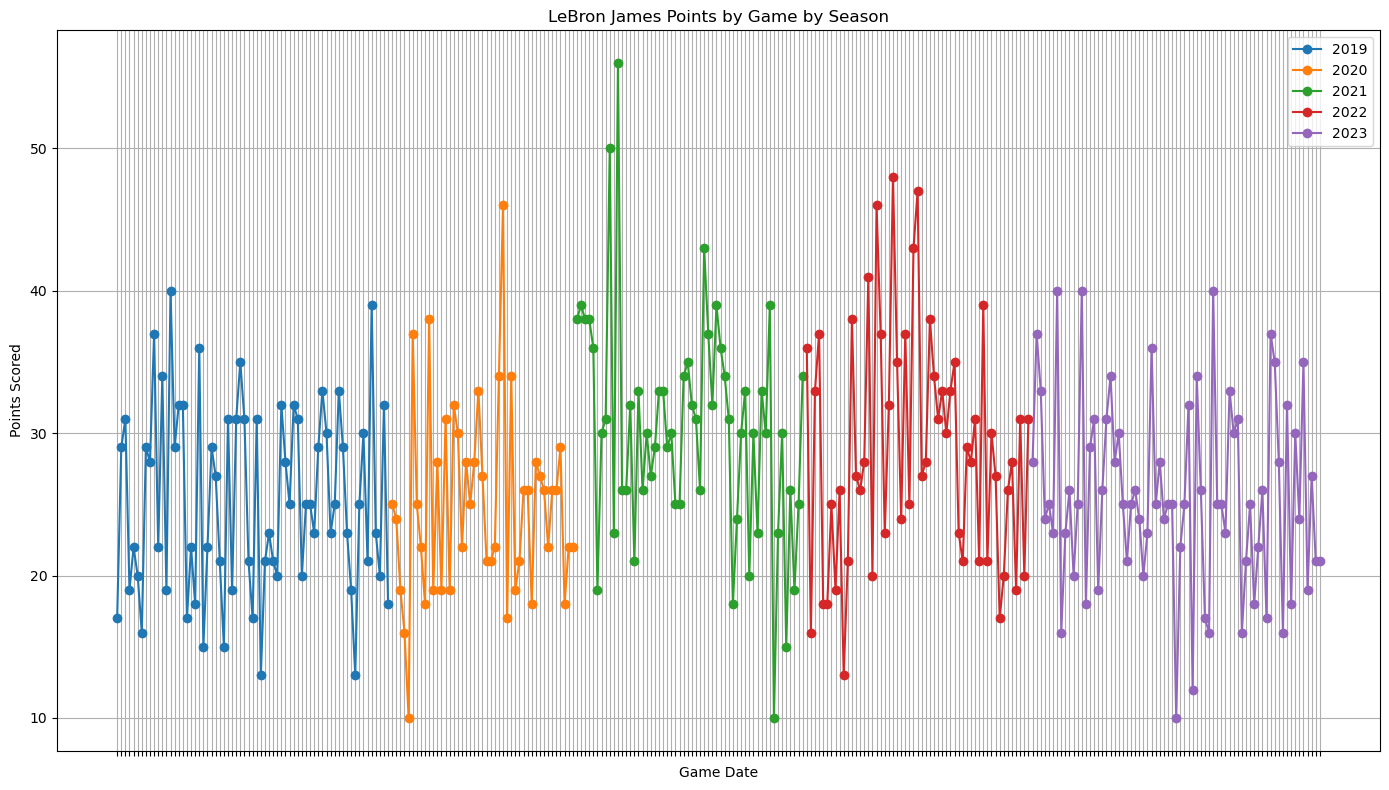

In [23]:
plt.figure(figsize=(14, 8))
for season in seasons:
    season_data = lebron_data[lebron_data['SEASON_ID'] == '2'+str(season)]
    plt.plot(season_data['GAME_DATE'], season_data['PTS'], marker='o', linestyle='-', label=season)

plt.title('LeBron James Points by Game by Season')
plt.xlabel('Game Date')
plt.ylabel('Points Scored')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.gca().set_xticklabels([])

plt.tight_layout()
plt.show()

As expected, it seems like the behaviour of Lebron's point generation is slightly different each season. For example, looking at 2021 and 2022, there is a distinct positive trend followed by a negative trend 

#### Investigating the Connection between LeBron and Anthony Davis's Points
Like many other teams in the NBA, Lebron is not the only All-Star player on the Lakers. He is accompanied by Anthony Davis, an elite big in the NBA. The Lakers strategy and game in recent years has revolved around these two players. 

Let's investigate Anthony Davis's point generation and game play status to see if this could be the cause of the trends in Lebron's point generation.

In [25]:
# Collect stats on games  Anthony Davis Played in 2020 to 2023 seasons
ad_id = get_player_id("Anthony Davis")

ad_data = pd.DataFrame()

for season in seasons:
    ad_season_data = get_player_gamelog(ad_id, season)
    ad_data = pd.concat([ad_data, ad_season_data])
    


In [27]:
# Collect stats on laker games from 2020 to 2023 seasons
from nba_api.stats.endpoints import LeagueGameFinder
from datetime import datetime

team_id = '1610612747'  # Los Angeles Lakers team ID

# DataFrame of Laker Games
game_finder = LeagueGameFinder(team_id_nullable=team_id)
game_data_frames = game_finder.get_data_frames()
gdf = game_data_frames[0]

# Convert to datetime
gdf['GAME_DATE'] = pd.to_datetime(gdf['GAME_DATE'])
laker_games = gdf[gdf['SEASON_ID'].isin(['22019','22020', '22021', '22022', '22023']) ]


In [28]:
# Merge all three data frames
lebron_data['GAME_DATE'] = pd.to_datetime(lebron_data['GAME_DATE'])
ad_data['GAME_DATE'] = pd.to_datetime(ad_data['GAME_DATE'])

lebron_points = lebron_data[['GAME_DATE', 'PTS']].rename(columns={'PTS': 'PTS_LeBron'})
ad_points = ad_data[['GAME_DATE', 'PTS']].rename(columns={'PTS': 'PTS_AD'})

merged_data = pd.merge(laker_games[['SEASON_ID','GAME_DATE']], lebron_points, on='GAME_DATE', how='left')
merged_data = pd.merge(merged_data, ad_points, on='GAME_DATE', how='left')

merged_data_with_NA = merged_data.copy()
merged_data = merged_data.fillna(0)

/var/folders/vr/7j3r04fd5sd0mn53h_jrc5q00000gn/T/ipykernel_90802/1498422547.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lebron_data['GAME_DATE'] = pd.to_datetime(lebron_data['GAME_DATE'])
/var/folders/vr/7j3r04fd5sd0mn53h_jrc5q00000gn/T/ipykernel_90802/1498422547.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ad_data['GAME_DATE'] = pd.to_datetime(ad_data['GAME_DATE'])


In [29]:
def plot_season_points(season_data, season_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot LeBron's points
    ax.plot(season_data['GAME_DATE'], season_data['PTS_LeBron'], marker='o', linestyle='-', label='LeBron James')
    
    # Plot AD's points
    ax.plot(season_data['GAME_DATE'], season_data['PTS_AD'], marker='x', linestyle='-', label='Anthony Davis')
    
    ax.set_title(f'LeBron James and Anthony Davis Points by Game ({season_name})')
    ax.set_xlabel('Game Date')
    ax.set_ylabel('Points Scored')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

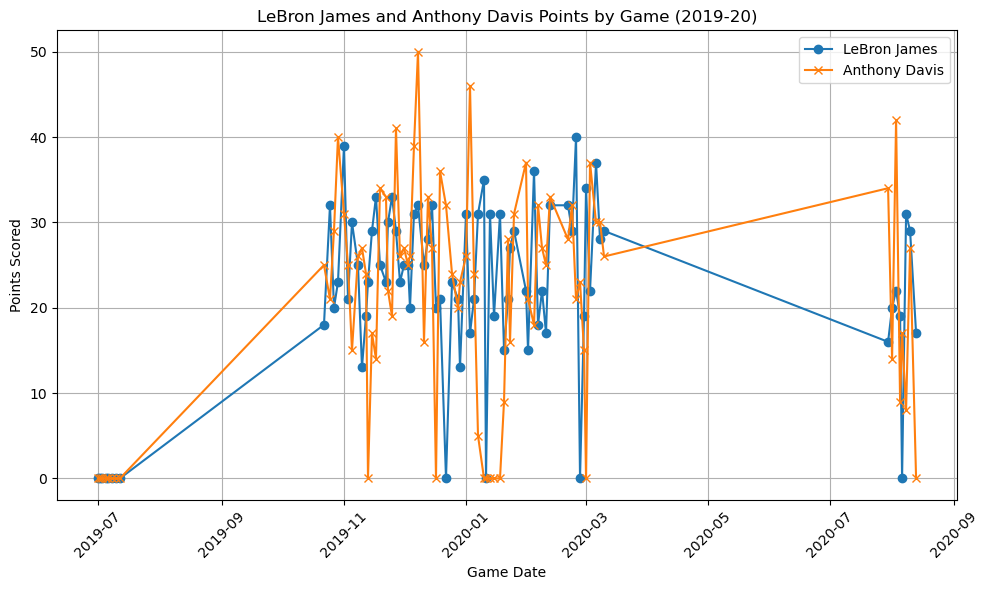

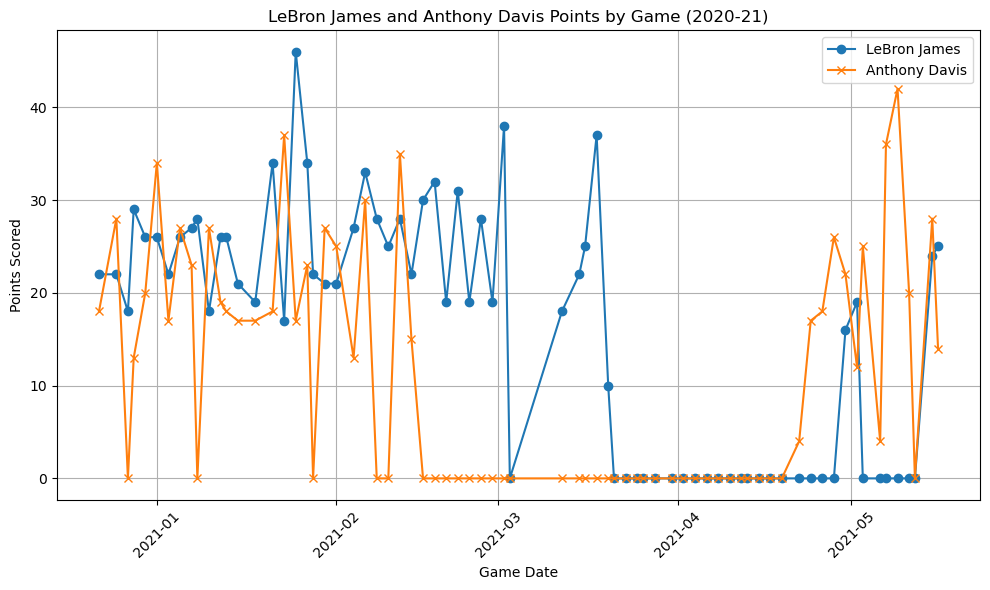

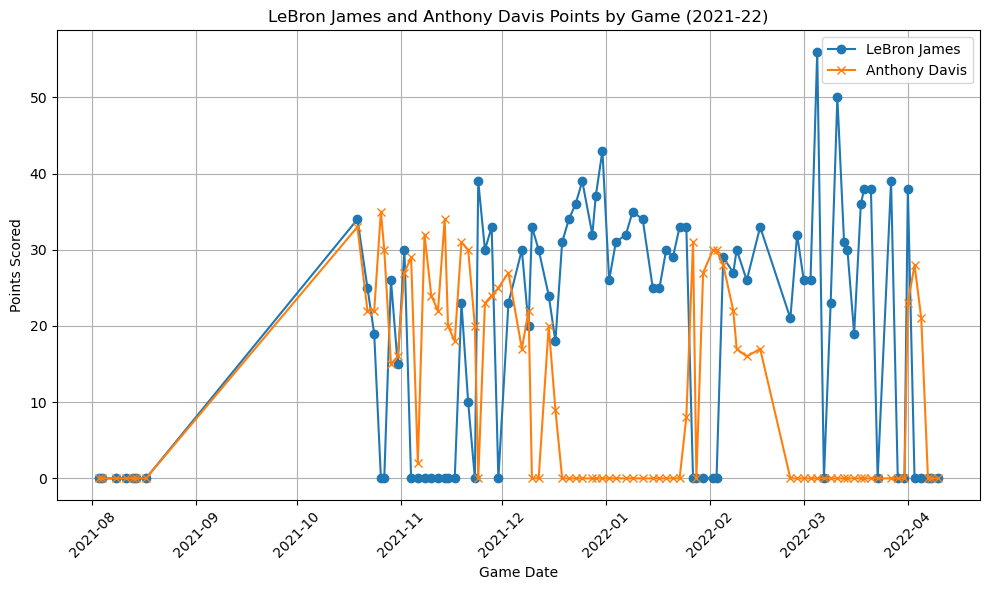

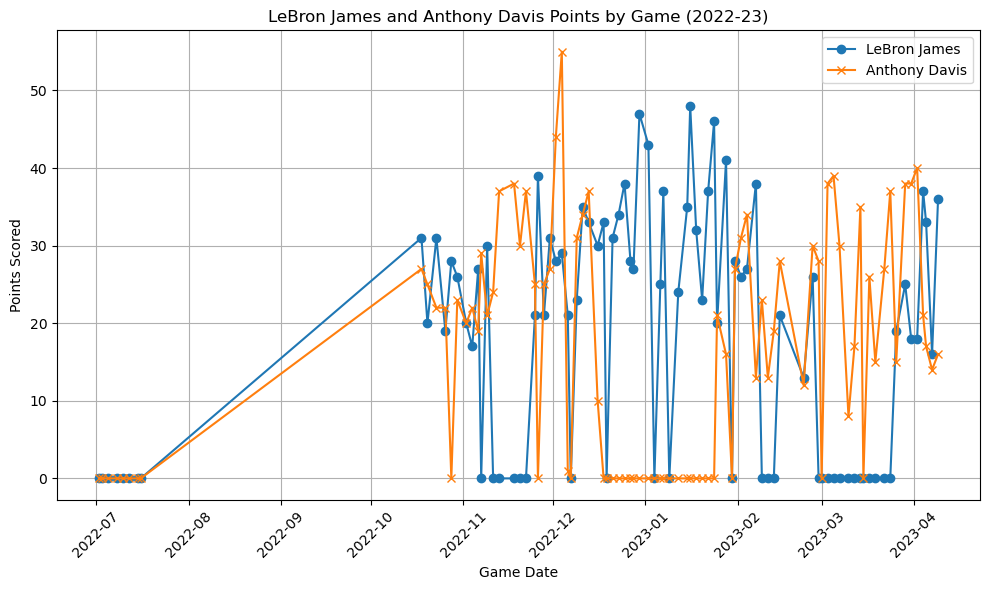

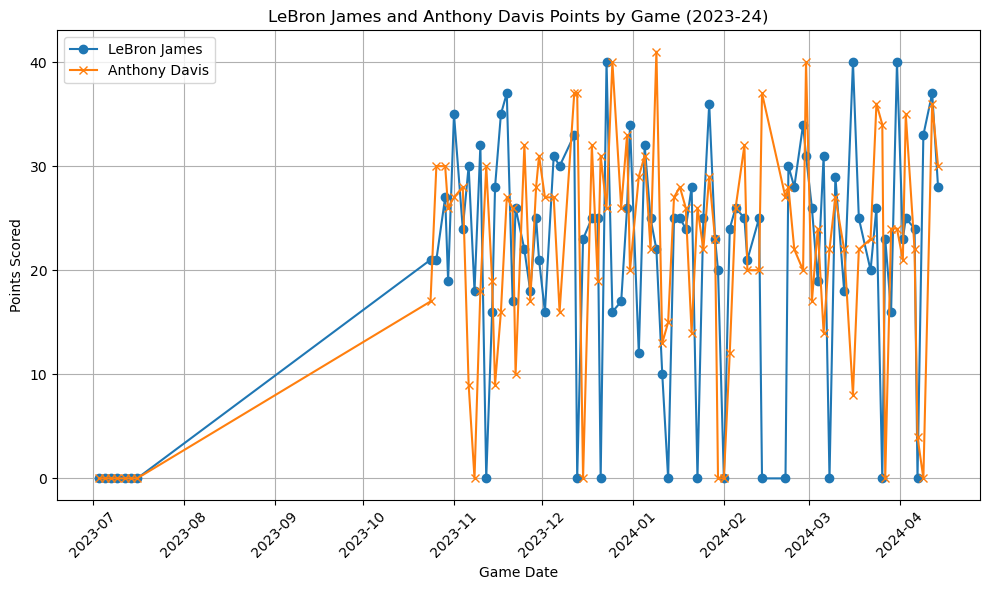

In [30]:
for season_id, season_name in [('22019', '2019-20'),('22020', '2020-21'), ('22021', '2021-22'), ('22022', '2022-23'), ('22023', '2023-24')]:
    # Filter data for the current season
    season_data = merged_data[merged_data['SEASON_ID'] == season_id]
    
    # Call the plotting function
    plot_season_points(season_data, season_name)

From these plots, we can see clearly that Lebron's points experience more stable variance in seasons 2019-2020 and 2023-2024 where Anthony Davis and himself are not often injured. This indicates that Anthony Davis's absence has some effect on Lebron's point generation and vice versa. 

Let's investigate the correlation between Anthony Davis's points and Lebron's points.

In [32]:
lebronyes = merged_data[merged_data['PTS_LeBron'] !=0]

ad_no = lebronyes[lebronyes['PTS_AD'] == 0].groupby('SEASON_ID')['PTS_LeBron'].agg(['mean', 'var', 'count'])

ad_yes = lebronyes[lebronyes['PTS_AD'] != 0].groupby('SEASON_ID')['PTS_LeBron'].agg(['mean', 'var', 'count'])

ad_no_yes = pd.merge(ad_no, ad_yes, on = 'SEASON_ID',how = 'outer')

ad_no_yes = ad_no_yes.rename(columns = {'mean_x': 'ppg_no_ad','mean_y': 'ppg_yes_ad', 'var_x': 'var_no_ad', 'count_x': 'count_no_ad','var_y': 'var_yes_ad', 'count_y': 'count_yes_ad' })
ad_no_yes['lebron_games_played'] = 82 - ad_no_yes['count_no_ad']
ad_no_yes

,ppg_no_ad,var_no_ad,count_no_ad,ppg_yes_ad,var_yes_ad,count_yes_ad,lebron_games_played
SEASON_ID,,,,,,,
22019,26.250000,52.785714,8,25.220339,42.726476,59,74
22020,24.944444,52.879085,18,25.074074,40.609687,27,64
22021,32.911765,57.234403,34,26.181818,46.536797,22,48
22022,34.473684,60.152047,19,25.972222,48.256349,36,63
22023,23.400000,33.300000,5,25.833333,45.248718,66,77


For the 2021 and 2022 seasons, there is a significant increase in points when Davis is not playing. Let's see if we can draw any numerical connection between these aggregation with a correlation matrix.

In [33]:
ad_no_yes[['ppg_no_ad', 'ppg_yes_ad', 'count_no_ad', 'count_yes_ad']].corr()

,ppg_no_ad,ppg_yes_ad,count_no_ad,count_yes_ad
ppg_no_ad,1.000000,0.660570,0.727604,-0.595905
ppg_yes_ad,0.660570,1.000000,0.489222,-0.180818
count_no_ad,0.727604,0.489222,1.000000,-0.908101
count_yes_ad,-0.595905,-0.180818,-0.908101,1.000000


It seems like LeBron's ppg without ad is positively correlated with the number of games where Davis is abscent. This could mean an interaction term including Davis's Status and Davis's number of missed games could be a useful predictor. 

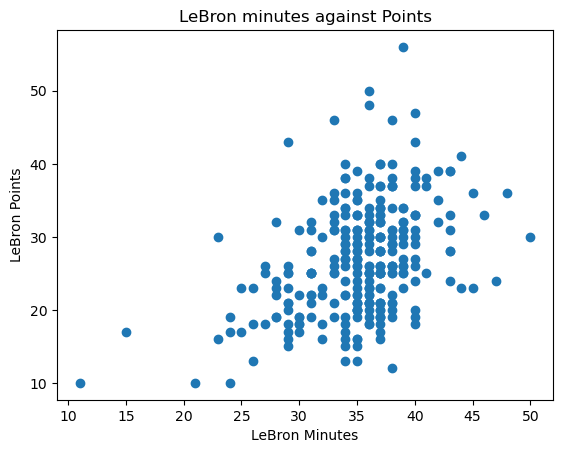

In [34]:
# Investigate the role of minutes relative to points
plt.scatter(lebron_data['MIN'], lebron_data['PTS'])
plt.xlabel('LeBron Minutes')
plt.ylabel('LeBron Points')
plt.title('LeBron minutes against Points')

plt.show()

It looks like LeBron's minutes are fairly linearly correlated with LeBron's points. Let's see if recent games have an effect on LeBron's future minutes.


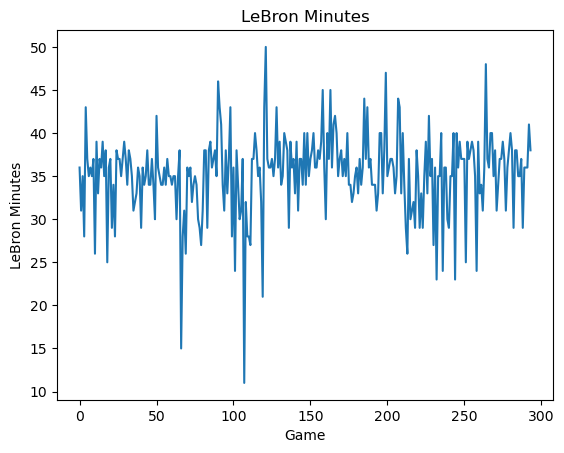

In [35]:
temp = lebron_data.sort_values(by = 'GAME_DATE').reset_index()

plt.plot(temp['MIN'])
plt.xlabel('Game')
plt.ylabel('LeBron Minutes')
plt.title('LeBron Minutes')

plt.show()

It seems like LeBron's minutes might be an equally difficult task to predict, so this might be something I leave for the future to investigate. 

#### Identifying Suitable Model for LeBron's Points

Let's investigate the autocorrelation of Lebron's points.

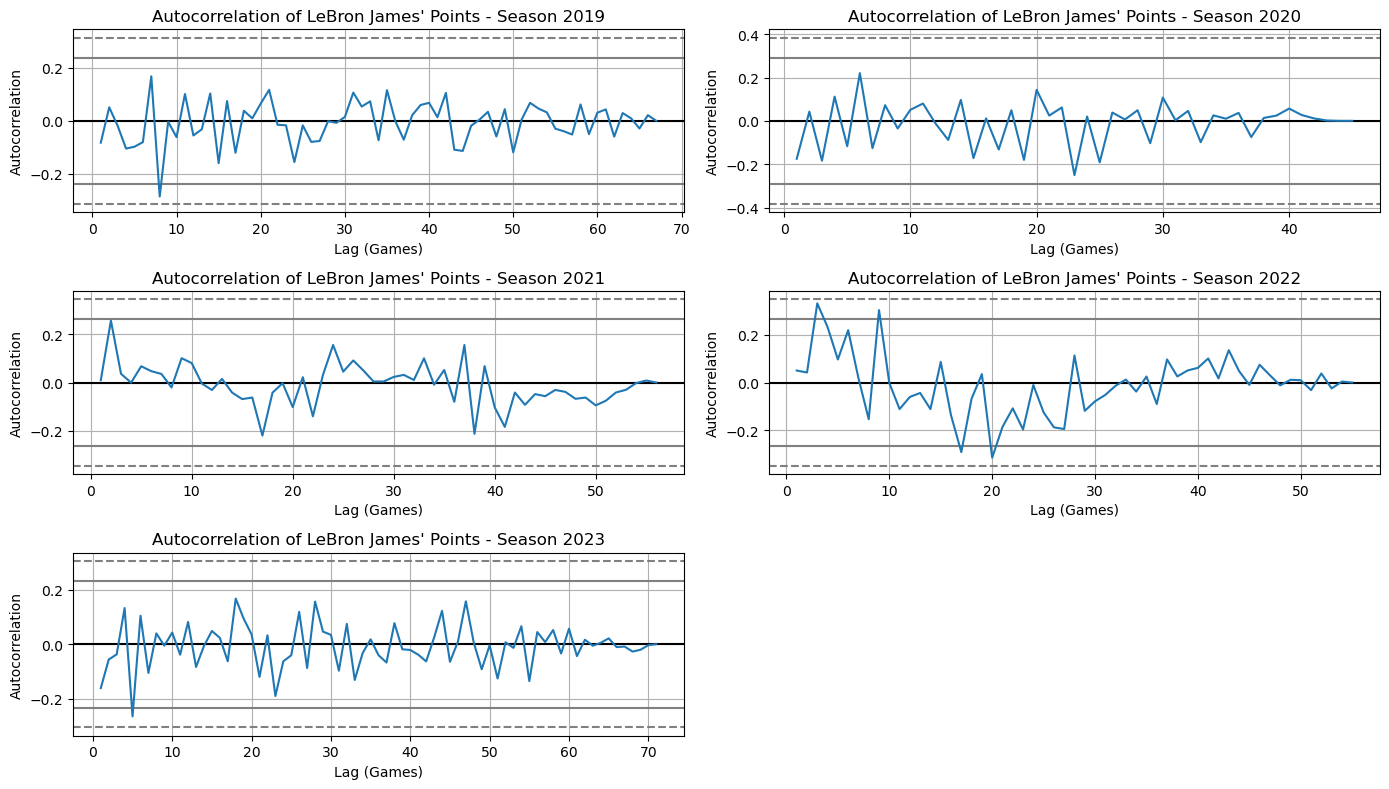

In [36]:
lebron_data = lebron_data.sort_values(by='GAME_DATE')

# Calculate autocorrelation by season

plt.figure(figsize=(14, 8))

for i, season in enumerate(seasons[0:5]):
    season_data = lebron_data[lebron_data['SEASON_ID'] == '2'+str(season)]
    autocorr = season_data['PTS'].autocorr()

    plt.subplot(3, 2, i + 1)
    pd.plotting.autocorrelation_plot(season_data['PTS'], ax=plt.gca())
    plt.title(f"Autocorrelation of LeBron James' Points - Season {season}")
    plt.xlabel('Lag (Games)')
    plt.ylabel('Autocorrelation')
    plt.grid(True)

plt.tight_layout()
plt.show()

There is very little autocorrelation in points for each of Lebron's seasons with the Lakers. Despite the temporal structure of a basketball season, it does not seem like the points from previous games are enough to predict future points. This implies that a simple Time Series model will not be sufficient for our goal. 

Let's see if we can model lebron's points using common distributions. 

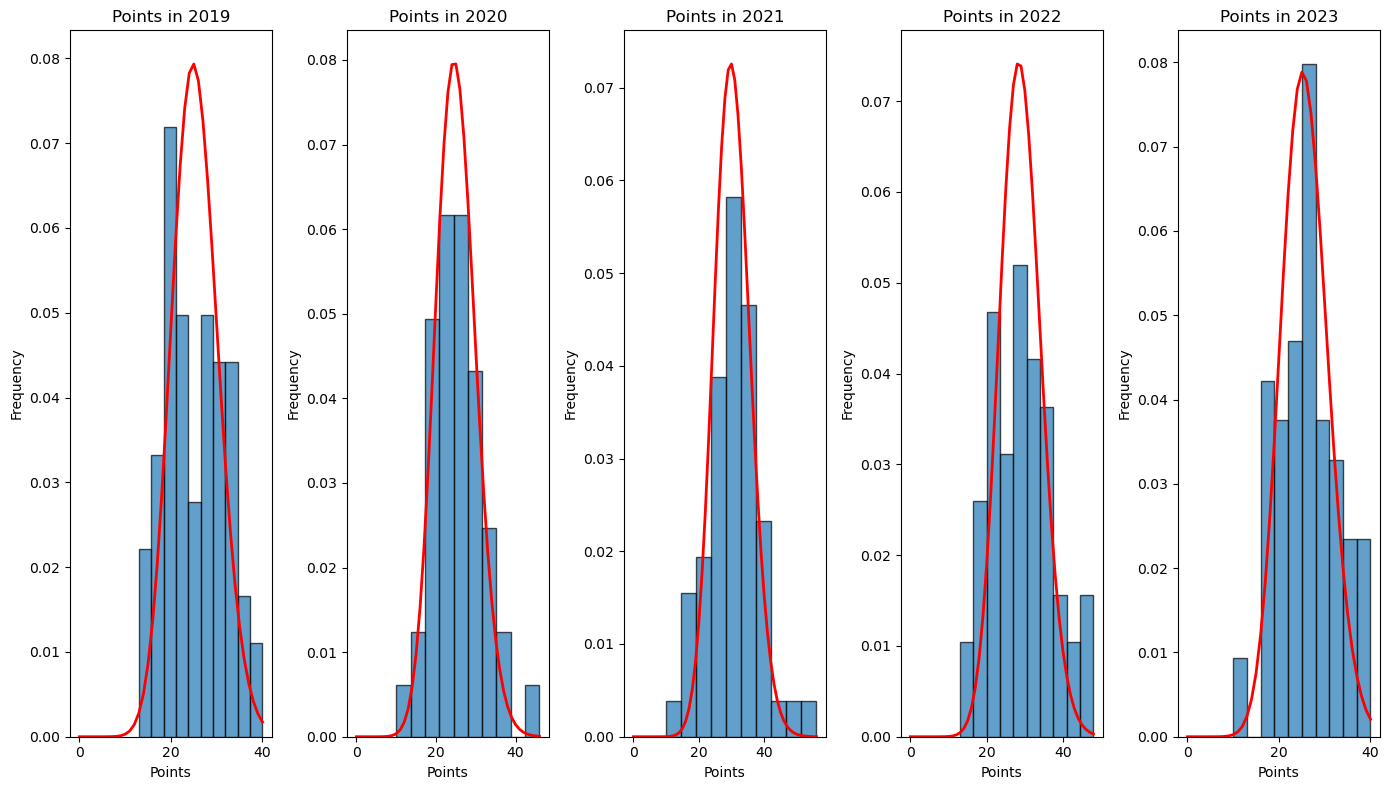

In [37]:
from scipy.stats import poisson
# Plot histograms for each season
plt.figure(figsize=(14, 8))
for i, season in enumerate(seasons[:5]):
    plt.subplot(1, len(seasons), i + 1)
    season_data = lebron_data[lebron_data['SEASON_ID'] == '2'+ str(season)]
    count, bins, ignored = plt.hist(season_data['PTS'], bins=10, edgecolor='black', alpha=0.7, density = True)
    
    mean_points = season_data['PTS'].mean()
    poisson_dist = poisson.pmf(range(int(bins[-1]) + 1), mean_points)
    plt.plot(range(int(bins[-1]) + 1), poisson_dist, 'r-', lw=2)
    
    plt.title(f'Points in {season}')
    plt.xlabel('Points')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Above is a plot of the histograms of Lebron's points each season overlayed with the pmf of the poisson distribution with the rate parameter being the mean points that season. 

It seems like the variance is slightly larger in our data than then the theoretical poission distribution. Let's instead try the negative binomial distribution which can capture this larger dispersion. 

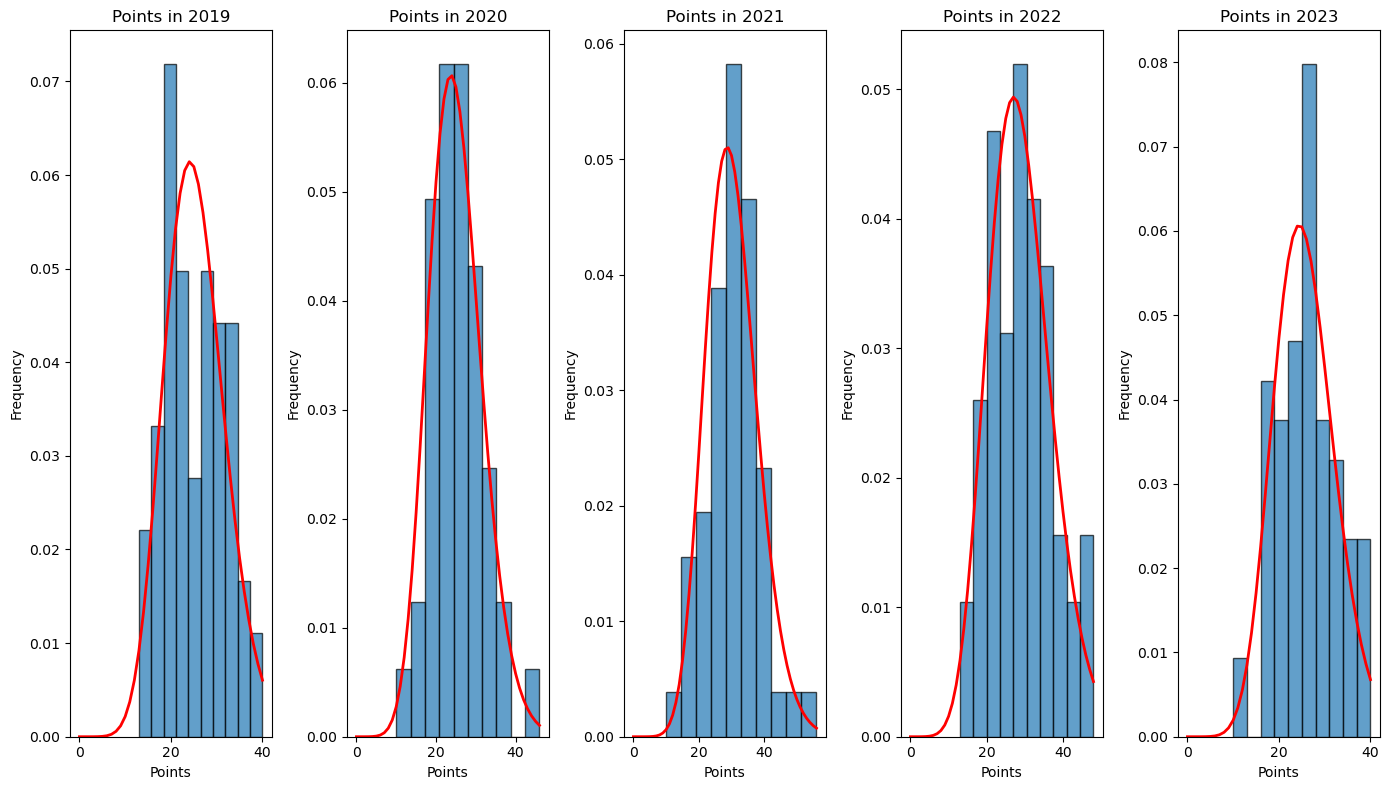

In [39]:
from scipy.stats import nbinom
# Plot histograms for each season
plt.figure(figsize=(14, 8))
for i, season in enumerate(seasons[:5]):
    plt.subplot(1, len(seasons), i + 1)
    season_data = lebron_data[lebron_data['SEASON_ID'] == '2'+ str(season)]
    count, bins, ignored = plt.hist(season_data['PTS'], bins=10, edgecolor='black', alpha=0.7, density = True)
    
    mean_points = season_data['PTS'].mean()
    var_points = season_data['PTS'].var()
    
    poisson_dist = nbinom.pmf(range(int(bins[-1]) + 1), mean_points**2 / (var_points - mean_points),mean_points/var_points)
    plt.plot(range(int(bins[-1]) + 1), poisson_dist, 'r-', lw=2)
    
    plt.title(f'Points in {season}')
    plt.xlabel('Points')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Aside from 2023 and maybe 2019, It seems like the theoretical negative binomial distribution fits the data more than that of the poisson. 

Let's try to use Negative Binomial Regression to model Lebron's points. In order to do so, lets concretely define our model. 

## Model Choice and Justification

### Negative Binomial Distribution as a Poisson-Gamma mixture
As concluded earlier, the Poisson distribution does not seem to capture enough variability in the response because of its lack of a dispersion parameter. 

However, by estabilishing a gamma prior on the poisson rate parameter, 

\begin{aligned}
y &\sim Poisson(\lambda) \\
\lambda &\sim Gamma(\alpha,\beta) 
\end{aligned}

the resulting marginal distribution of $y$ will be negative binomial:


\begin{aligned}
p(y) &= \int_0^{\infty} p(y \mid \lambda)p(\lambda)d\lambda \\
&= \int_0^\infty \left( \frac{y!}{\lambda^y} e^{-\lambda} \right) \left( \frac{\Gamma(\alpha) \beta^\alpha \lambda^{\alpha - 1} e^{-\beta \lambda}}{\Gamma(\alpha)} \right) d\lambda \\
&= \frac{\Gamma(y + \alpha)}{\Gamma(y + 1) \Gamma(\alpha)} \left( \frac{\beta}{\beta + 1} \right)^\alpha \left( \frac{1}{\beta + 1} \right)^y \\
&= \text{NB}(\alpha, \beta)
\end{aligned}

For full proof (with different parametrization) see: https://gregorygundersen.com/blog/2019/09/16/poisson-gamma-nb/

Defining the hierarchical relationship helps explain the use of negative binomial regression. 

### Negative Binomial Regression for Predicting LeBron's Points

The negative binomial regression model is given by:

$$
\log(\mu_i) = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \ldots + \beta_kX_{ik}
$$

where:
- $i \in L$, in which $L$ is the set of indices of games in which LeBron played in the game
- $\mu_i = \mathbb{E}[Y_i]$
- $Y_i$ is the count response variable: LeBron's points on the ith game of a given season.
- $X_{i1}, X_{i2}, \ldots, X_{ik}$ are the predictor variables (e.g.: LeBron's ppg that season, statistics from the opponent team, etc)
- $\beta_0, \beta_1, \beta_2, \ldots, \beta_k$ are the coefficients.

#### Probability Mass Function in Regression Context

The negative binomial distribution is parameterized by the mean $\mu_i$ and the dispersion parameter $\alpha$. 

We utilize the fact that the mean of Negative Binomial is:

$$
\mu_i = \frac{\alpha}{\beta}
$$

Then solve for $\beta$ to rearrange the terms:
$$
\beta= \frac{\alpha}{\mu_i}

$$

Then plug this $\beta$ into the pmf earlier to get the probability mass function:

$$
P(Y_i = y \mid \mu_i, \alpha) = \frac{\Gamma(y + \alpha)}{\Gamma(y + 1) \Gamma(\alpha)} \left( \frac{\alpha}{\alpha + \mu_i} \right)^\alpha \left( \frac{\mu_i}{\alpha + \mu_i} \right)^y
$$

To infer the distribution of LeBron's points on the ith game we can use our regression model to estimate $P(Y_i = y)$ by estimating $\mu_i$ using: 
$$
\mu_i = \exp \bigg( \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \ldots + \beta_kX_{ik}\bigg)
$$

For the purpose of predicting LeBron's points though, all we need is to compute $\mu_i$

#### Some potential problems to look out for

The Negative Binomial Regression model assumes a linear connection between our predictors and the log of LeBron's points. It is very possible that there are significant nonlinear underlying effects that our model cannot effectively pick up. There are ways to get around this, such as feature transformations or including interaction terms, but it can be tedious to identify every single one of these. 

Another possible roadblock is the time correlation between each game. Although there was no distinct pattern in the autocorrelation of LeBron's points, it would be ignorant to assume that past games do not effect future games. In the next section, we'll engineer features in order to account for this. 



## Feature Selection and Engineering
Recalling that the goal of our model is to predict LeBron's Points on the ith game, we need to make sure we only use data that is available before the ith game. 

Here are some possible sets of data that are available before the game:
- Data from Previous Games
- Data from Previous Seasons
- The Starting Lineup for the ith Game
- The Status of each player for the ith Game
- The Opponent Team and data from their previous Games



### Utilizing Data from Previous Games
Our goal is to predict LeBron's points before the game occurs, so we obviously will not have access to any data that also pans out in the game. In other words, we should train our model on data accumulated from games prior to the ith game.


Rigorously, suppose $D_{i1}, \dots, D_{id}$ is a set of data consisting of $d$ features obtained solely game $i$. If we were modeling LeBron's Points $Y_i$ for the ith game, a given predictor $X_{ik}$ would be some function $g(\cdot)$ of the folowing matrix: 
$$
D = \begin{pmatrix}
D_{1,1} & D_{1,2} & \cdots & D_{1,d} \\
D_{2,1} & D_{2,2} & \cdots & D_{2,d} \\
\vdots & \vdots & \ddots & \vdots \\
D_{i-1,1} & D_{i-1,2} & \cdots & D_{i-1,d}
\end{pmatrix}
$$
For example, LeBron's PPG heading into the 20th game of the season would be represented as:

$$
\begin{aligned}
X_{20,\text{ppg}} &= g(D_{1,\text{points}}, \dots, D_{19,\text{points}}) \\
&= \text{mean}(D_{1,\text{points}}, \dots, D_{19,\text{points}}) \\
&= 1/19\sum_{i=1}^{19}D_{i,\text{points}}
\end{aligned}
$$

where $D_{i,\text{points}}$ is LeBron's points on the ith game.


However, for predicting games that are early in the season, our matrix of predictors $X_{11}, X_{12}, \dots,  X_{ik}$ might have a lot more dimensionality than actual observations, i.e. $k$ will be much larger than $i$. This could cause the model to struggle to capture underlying patterns that connect our predictors to the response, instead leading to overfitting of the noise from the training data. 


### Incorporating Data from Previous Seasons
One solution to this problem is to incorporate data from previous seasons. It is important to note that there are many factors that come from a change between seasons that could be influencing LeBron's Points, and if we are not careful we could be introducing a lot of bias into our model. With some modifications and constraints, this could be worked around. Some things to consider:

- The Lakers roster has gone through many changes, but LeBron's role on the team has stayed fairly consistent, and the same can be said about Anthony Davis. As for the rest of the players, we could pool them into overarching roles, such as starters, bench, etc. 
- We can utilize predictors that are functions of lagged variables. For example, instead of using LeBron's career ppg as a predictor, we can compute a ppg that is simply the mean of LeBron's points in the last 5 games, i.e. from games $i-5$ to $i-1$. In doing so, we can avoid implementing bias and instead capture extra information from past seaons on how recent games affect future games.

Here are some possible predictors to consider:
- LeBron's points in recent games. 
- LeBron's game status right before game (e.g.: probable, questionable, etc...)
- Whether the game is a back to back
  





### Incorporating Statistics of Teammates
Recall that in estabilishing $i \in L$, we are only considering data from games in which LeBron played in. So, datasets from our teammates should also only contain games from the the set $L$.  It is obvious that games LeBron is abscent in behave different than games he particpiates in. Therefore, it would be unwise to use statistics from games that do not directly involve LeBron's own point generation. 



##### Starting Lineup 
Going into the ith game, we are informed of the starting 5 for the night. Generally, the starting 5 play the most minutes within a given game, so these players will have the most influence on how the game pans out. However, for any given Lakers roster there are several combinations of starters, and for each combination, there is likely only a handful of games with that specific lineup. With the many possible combinations and little observations for each combination, it would be statistically questionable to utilize the exact combination of starters as a predictor. 

Instead of focusing on the starting lineup, we will use at the average points scored by the starters in recent games as a predictor. With the cost of some information, pooling them together solves the problem of data shortage  while still capturing the general performance of the recent lineups. 

Factors to consider:
- bench points in recent games 
- starter points (minus Lebron) in recent games
  
##### Player Participation / Game Status
We have already performed some feature engineering looking at Anthony Davis's effect on LeBron's points. Though there was no direct linear correlation between their points, it is clear that Davis's participation has some type of effect on LeBron's Points. So for our regression model, we should include variables connected to Anthony Davis's participation in the game. 

- A simple way to incorporate Davis's participation would be to utilize a binary predictor representing Davis's status for the game (i.e. 1 for playing, 0 for not playing). Scaling this to other players might not be achievable, since not all players miss a substantial amount of games.
  
- Davis's minutes (or usage) could be a valuable predictor to represent his partipation, but it may be difficult to additionally predict how many minutes he would play on a given night. 

- This can also be scaled to other important players on the team






### Incorporating Statistics from the Opposing Team
When considering statisitcs from opposing teams, we run into similar problems as before. NBA teams are constantly changing, which means we once again are facing a data shortage issue. To combat this, we'll need to utilize statistics that can capture overarching effects despite these changes. Some factors from the opposing team to consider:

- Team Defensive Rating / Points allowed
  - Against a poor/strong defensive team, the Lakers will likely score more/less overall, which means LeBron might also score more/less 
- Position / Role of Opposing Team's Strongest Defensive Players
  - If specifically LeBron's defender is elite, we might expect less points from him
-  Game Importance
   -  possibily a difficult value to quantify
   -  if the game can be seen as "high stakes" LeBron might perform better than usual. 
-  LeagueDashTeamStats




### Selected Predictors
From the set of features brainstormed above, the first selection will be made with the goal of creating a base for the model that can find patterns without becoming too complex. The chosen predictors are:
- Rolling Averages (last 5 games):
  - LeBron's points
  - Starter points (minus LeBron)
  - Bench points
- Anthony Davis Statisitcs:
  - Game Status
  -  Games missed (in last 5 games)
- Opposing Team Stats
  - Team Defensive Rating
  - LeBron's defender defensive rating


## Extracting Our Data
Now that we've selected our features, we now must use nba_api to form our training dataset. In order to assess the performance of our model, we will use the second half of 2023-2024 season as our testing dataset. 

#### Rolling Average of LeBron's Points

In [139]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def compute_rolling_avg_ppg(player_game_logs, lag = None, total_ppg = None):
    if total_ppg:
        output= pd.DataFrame(columns =  ['SEASON_ID','LeBron_PPG_so_far', 'Game_ID'])
    else:
        output = pd.DataFrame(columns = ['SEASON_ID','LeBron_PPG_last_5', 'Game_ID'] )

    # Iterate by season
    for season in seasons:
        season_id  = '2' + str(season)
        season_data = player_game_logs[player_game_logs['SEASON_ID']==season_id]
        
        # Make sure data is sorted by Game Date
        season_data = season_data.sort_values(by = 'GAME_DATE').reset_index()
  
        # Define variables for iteration
        game_id = season_data['Game_ID'] 
        game_date = season_data['GAME_DATE']
        
        season_points = season_data['PTS'] 
        games_played = len(season_points)   
        
        # Add NaN for the first 5 games of every season
        
        if not total_ppg:  
            for i in range(0, lag):
                new_row = pd.DataFrame({'SEASON_ID' : [season_id], 'LeBron_PPG_last_5' : None, 'Game_ID': game_id[i], 'GAME_DATE': game_date[i]})      
                output = pd.concat([output, new_row], ignore_index=True)  
            
            # Compute and add the Rolling Averages for every game after the 5th game. 
            for i in range(lag, games_played):
                # Compute the average of the last 5 games
                avg_last_5 = np.mean(season_points[i-lag:i])
                # Append the average to the rolling averages list
                new_row = pd.DataFrame({'SEASON_ID' : [season_id], 'LeBron_PPG_last_5' : [avg_last_5], 'Game_ID': game_id[i],'GAME_DATE': game_date[i]})
                
                output = pd.concat([output, new_row], ignore_index=True)
        
        else:
            for i in range(0, games_played):
                avg_so_far = np.mean(season_points[0:i])
                new_row = pd.DataFrame({'SEASON_ID' : [season_id], 'LeBron_PPG_so_far' : [avg_so_far], 'Game_ID': game_id[i],'GAME_DATE': game_date[i]})
                
                output = pd.concat([output, new_row], ignore_index=True)
        
                
    return output #.drop(columns = ['PPG_last_5'])


lebron_rolling_averages_ppg = compute_rolling_avg_ppg(player_game_logs = lebron_data, lag = 3)

lebron_ppg_so_far = compute_rolling_avg_ppg(player_game_logs = lebron_data, total_ppg = True)

#ad_rolling_averages_ppg = compute_rolling_avg_ppg(ad_data)
#rolling_averages_ppg_no_NA = lebron_rolling_averages_ppg.dropna()  

pd.merge(lebron_ppg_so_far, lebron_rolling_averages_ppg, on = ['Game_ID', 'SEASON_ID', 'GAME_DATE'])








,SEASON_ID,LeBron_PPG_so_far,Game_ID,GAME_DATE,LeBron_PPG_last_5
0,22019,NaN,0021900002,2019-10-22,NaN
1,22019,18.000000,0021900025,2019-10-25,NaN
2,22019,25.000000,0021900040,2019-10-27,NaN
3,22019,23.333333,0021900054,2019-10-29,23.333333
4,22019,23.250000,0021900074,2019-11-01,25.000000
...,...,...,...,...,...
289,22023,25.378788,0022301103,2024-04-03,26.333333
290,22023,25.373134,0022301127,2024-04-06,29.333333
291,22023,25.352941,0022301155,2024-04-09,24.000000
292,22023,25.463768,0022301177,2024-04-12,27.333333


### Rolling Average Points for the rest of the Team
For the sake of simplicity, we will pool the players into two groups:
- Starters (minus LeBron)
- Bench


In [140]:

game_ids_by_season = []
for season in seasons:
    
    # Recall we are only interested in games LeBron played in, so we look at the game ids in lebron_data. 
    game_ids = lebron_data[lebron_data['SEASON_ID'] == '2'+ str(season)]['Game_ID']
    game_ids_by_season.append(game_ids)

In [49]:

from nba_api.stats.endpoints import BoxScoreTraditionalV2
import os
import pickle

# Gather boxscores for all games LeBron has played in
def get_boxscores_data_by_season(game_ids_by_season):
    boxscores_data_by_season = []

    for season_game_ids in game_ids_by_season:
        boxscores_data = pd.DataFrame()
        for game_id in season_game_ids:
            boxscore = BoxScoreTraditionalV2(game_id=game_id)
            boxscore_data = boxscore.get_data_frames()[0]
        
            # Combine Box Score with rest
            boxscores_data = pd.concat([boxscores_data, boxscore_data])
            print('Added Box Score')
            
        # Add season box scores to list 
        boxscores_data_by_season.append(boxscores_data)
        
        print('Added Season Box Scores')
    return boxscores_data_by_season


# I have already run this, so for simplicity, I will reload the presaved boxscores from the data directory
trad_path = os.path.join('..', 'data', 'traditional_boxscores.pkl')
with open(trad_path, 'rb') as file:
    boxscores_data_by_season = pickle.load(file)


In [1090]:
# For some reason, the above function does not provide the games that occured right when the bubble started

# Find ID's for said games
excluded_game_ids = lebron_rolling_averages_ppg[lebron_rolling_averages_ppg['GAME_DATE'].dt.month == 8]['Game_ID']

# Add boxscores from those games to the 2019-20 season boxscores
for game_id in excluded_game_ids: 
    boxscore = BoxScoreTraditionalV2(game_id=game_id)
    boxscore_data = boxscore.get_data_frames()[0]
    
    boxscores_data_by_season[0] = pd.concat([boxscores_data_by_season[0],boxscore_data])
    

In [141]:
team_rolling_averages_ppg = pd.DataFrame(columns = ['SEASON_ID','Starters_PPG_last_5', 'Bench_PPG_last_5','Game_ID', 'GAME_DATE'] )

# Iterate through the list of boxscores for each season
for season, boxscores in zip(seasons, boxscores_data_by_season):
    

    boxscores = boxscores[boxscores['TEAM_ABBREVIATION'] == 'LAL'].reset_index() # only laker player data
    game_ids = boxscores['GAME_ID'].unique() 
    season_id = '2' + str(season)
    
    # Utilize another dataframe that contains GAME_DATE because the boxscores for some reason don't have GAME_DATE
    check = LeagueGameFinder(team_id_nullable = '1610612747').get_data_frames()[0]
    check = check[check['GAME_ID'].isin(game_ids)]
    check['GAME_DATE'] = pd.to_datetime(check['GAME_DATE'])
    game_dates = check[['GAME_ID', 'GAME_DATE']]


    # Identify Starters
    boxscores['Starter'] = boxscores['START_POSITION'] != ''
    
    # Sum up the points for Starters and Bench
    starter_bench_pts = pd.DataFrame(boxscores.groupby(['GAME_ID','Starter'])['PTS'].sum()).reset_index()
    starter_bench_pts = pd.merge(starter_bench_pts, game_dates, on =  'GAME_ID', how = 'left')
    starter_bench_pts = starter_bench_pts.sort_values(by = 'GAME_DATE').reset_index()
    
  
    
    # Split between Starters and Bench
    starter_pts = starter_bench_pts[starter_bench_pts['Starter'] == True].reset_index()
    bench_pts =  starter_bench_pts[starter_bench_pts['Starter'] == False].reset_index()
    
    # Get LeBron Points
    lbj_pts = boxscores[boxscores['PLAYER_NAME'] == 'LeBron James'].reset_index()
    lbj_pts = pd.merge(lbj_pts, game_dates, on =  'GAME_ID', how = 'left')
    lbj_pts = lbj_pts.sort_values(by='GAME_DATE').drop_duplicates(subset='GAME_ID', keep='first').reset_index(drop = True)
    
    # Get Anthony Davis Points
    ad_boxscores = boxscores[boxscores['PLAYER_NAME'] == 'Anthony Davis'].rename(columns = {'PTS': 'AD_PTS'})
    ad_pts = pd.merge(lbj_pts, ad_boxscores[['GAME_ID', 'AD_PTS']], on = 'GAME_ID',how = 'left')[['AD_PTS', 'GAME_ID']].fillna(0)

    
    # Compute Starter PTS minus the PTS LeBron and Anthony contribute
    starter_pts['PTS_minus_LBJ'] = starter_pts['PTS'] - lbj_pts['PTS'] -ad_pts['AD_PTS']
    
    games_played = len(lbj_pts)

    # Sorted ID's and Dates
    game_ids = starter_pts['GAME_ID']
    game_dates = starter_pts['GAME_DATE']
    
    # Add NaN for the first 3 games of every season
    for i in range(0, 3):
        
        new_row = pd.DataFrame({'SEASON_ID' : [season_id], 'Starters_PPG_last_5' : None, 'Bench_PPG_last_5':None, 'Game_ID': game_ids[i], 'GAME_DATE': game_dates[i]})      
        team_rolling_averages_ppg = pd.concat([team_rolling_averages_ppg, new_row], ignore_index=True) 
        #bench_rolling_averages_ppg = pd.concat([bench_rolling_averages_ppg, new_row], ignore_index=True)   
    
    # Compute and add the Rolling Averages for every game after the 5th game. 
    for i in range(3, games_played):
        
        # Compute the average of the last 5 games
        starter_avg_last_5 = np.mean(starter_pts['PTS_minus_LBJ'][i-3:i])
        bench_avg_last_5 = np.mean(bench_pts['PTS'][i-3:i])
        date = starter_pts['GAME_DATE']
        # Create row containing rolling average
        
        team_new_row = pd.DataFrame({'SEASON_ID' : [season_id], 'Starters_PPG_last_5' : [starter_avg_last_5], 'Bench_PPG_last_5' : [bench_avg_last_5],'Game_ID': game_ids[i],'GAME_DATE': game_dates[i]})

        # Add row to existing Data Frame
        team_rolling_averages_ppg = pd.concat([team_rolling_averages_ppg, team_new_row], ignore_index=True)

        
team_rolling_averages_ppg = team_rolling_averages_ppg[team_rolling_averages_ppg['Game_ID'].isin(lebron_data['Game_ID'])]
team_rolling_averages_ppg
            


,SEASON_ID,Starters_PPG_last_5,Bench_PPG_last_5,Game_ID,GAME_DATE
0,22019,NaN,NaN,0021900002,2019-10-22
1,22019,NaN,NaN,0021900025,2019-10-25
2,22019,NaN,NaN,0021900040,2019-10-27
3,22019,27.000000,30.333333,0021900054,2019-10-29
4,22019,23.666667,33.000000,0021900074,2019-11-01
...,...,...,...,...,...
289,22023,44.000000,18.000000,0022301103,2024-04-03
290,22023,49.666667,17.333333,0022301127,2024-04-06
291,22023,47.000000,26.000000,0022301155,2024-04-09
292,22023,54.000000,20.000000,0022301177,2024-04-12


### Anthony Davis Status and Games Missed
- Game Status (yes if Davis played more than 5 minutes)
- Games Missed (how many games Davis has missed in a row)

In [142]:
# Creating a merged data frame that contains from all laker games

lebron_data['GAME_DATE'] = pd.to_datetime(lebron_data['GAME_DATE'])
ad_data['GAME_DATE'] = pd.to_datetime(ad_data['GAME_DATE'])

lebron_mins = lebron_data[['GAME_DATE', 'MIN']].rename(columns={'MIN': 'MIN_LeBron'})
ad_mins = ad_data[['GAME_DATE', 'MIN']].rename(columns={'MIN': 'MIN_AD'})

merged_data = pd.merge(laker_games[['SEASON_ID','GAME_DATE', 'GAME_ID']], lebron_mins, on='GAME_DATE', how='left')
merged_data = pd.merge(merged_data, ad_mins, on='GAME_DATE', how='left')


merged_data = merged_data.fillna(0)

merged_data['AD_Yes'] = merged_data['MIN_AD']> 15

merged_data



,SEASON_ID,GAME_DATE,GAME_ID,MIN_LeBron,MIN_AD,AD_Yes
0,22023,2024-04-14,0022301195,38.0,33.0,True
1,22023,2024-04-12,0022301177,41.0,43.0,True
2,22023,2024-04-09,0022301155,36.0,0.0,False
3,22023,2024-04-07,0022301143,0.0,12.0,False
4,22023,2024-04-06,0022301127,36.0,36.0,True
...,...,...,...,...,...,...
414,22019,2019-07-06,1521900016,0.0,0.0,False
415,22019,2019-07-05,1521900006,0.0,0.0,False
416,22019,2019-07-03,1321900006,0.0,0.0,False
417,22019,2019-07-02,1321900003,0.0,0.0,False


In [143]:
# Compute how many games in a row Davis has missed prior to current Game
streak_list = []
game_ids = []

# Iterate through each row to calculate streak of missed games
for season in seasons:
    ad_missed_streak = 0
    
    # Divide by season to avoid streaks incrementing across seasons
    season_data = merged_data[merged_data['SEASON_ID'] == '2'+ str(season)].reset_index(drop = True)
    
    # Add streak of 0 and save game id for first game of every season
    streak_list.append(0)
    game_ids.append(season_data['GAME_ID'][0])
    
    # Start streak counter on second game of season
    for i in range(1, len(season_data['GAME_ID'])):
        for j in range(0,i):
            if season_data['AD_Yes'][j]:
                ad_missed_streak = 0 # Reset streak counter
            else:
                ad_missed_streak += 1  # Increment streak counter
        game_ids.append(season_data['GAME_ID'][i])
        streak_list.append(ad_missed_streak) # Store current streak value
        
ad_streak_df = pd.DataFrame({"AD_miss_streak" :streak_list, 'GAME_ID': game_ids})


merged_data = pd.merge(merged_data, ad_streak_df, on = 'GAME_ID', how = 'left')

In [144]:
# Only utilize games LeBron played in to match rest of dataset
ad_status_factors = merged_data[merged_data['MIN_LeBron'] > 0]

ad_status_factors = ad_status_factors[['SEASON_ID', 'GAME_ID', 'AD_Yes', 'AD_miss_streak']]
ad_status_factors = ad_status_factors.rename(columns = {'GAME_ID':'Game_ID'})
ad_status_factors

,SEASON_ID,Game_ID,AD_Yes,AD_miss_streak
0,22023,0022301195,True,0
1,22023,0022301177,True,0
2,22023,0022301155,False,0
4,22023,0022301127,True,2
5,22023,0022301103,True,0
...,...,...,...,...
406,22019,0021900074,True,0
407,22019,0021900054,True,0
408,22019,0021900040,True,0
409,22019,0021900025,True,0


### Opposing Team Stats
  - Team Defensive Rating
  - LeBron's defender defensive rating

In [145]:
# Convert Season ID to format required for API function in next cell
def convert_season_id(season_id):
    start_year = int(season_id[1:5])
    end_year = start_year + 1
    return f"{start_year}-{str(end_year)[-2:]}"
lebron_data['GAME_DATE'] = pd.to_datetime(lebron_data['GAME_DATE'])
date_season= lebron_data.reset_index(drop = True)

# Gather Season and Date for API function in next cell
date_season['DATE'] = date_season['GAME_DATE'].apply(lambda x: x.strftime('%m/%d/%Y'))
date_season['SEASON'] = date_season['SEASON_ID'].apply(convert_season_id)



In [147]:
from nba_api.stats.endpoints import LeagueDashTeamStats

def get_opp_team_date(date_season):
    opp_team_data = pd.DataFrame()
    count = 0
    
    # Getting Defense Data for teams accumulated from games before each date
    for season,date in zip(date_season['SEASON'], date_season['DATE']):

        count = count +1 
        print(date)
        teams = pd.DataFrame(LeagueDashTeamStats(measure_type_detailed_defense = 'Defense',season = season, date_to_nullable=date, timeout=300).get_data_frames()[0])
        
        # Combine with other seasons
        teams['GAME_DATE'] = date
        opp_team_data = pd.concat([opp_team_data, teams])
    
    
# Loading in opp_team_data that I've already saved into data directory
file_path = os.path.join('..', 'data', 'opp_team_data.csv')

# Load the CSV file into a DataFrame
opp_team_data = pd.read_csv(file_path)


In [148]:
# The date_season dataframe does not have an Opposing Team ID column, so we will extract the abbreviation from the Matchup Column:

def extract_match_details(matchup):
    if 'vs.' in matchup:
        teams = matchup.split('vs.')
        game_type = 'home'
    elif '@' in matchup:
        teams = matchup.split('@')
        game_type = 'away'
    
    for team in teams:
        team = team.strip()
        if team != 'LAL':
            return [team, game_type]

# Now we will find the Team ID for the assoicated abbreviation
def abbrev_to_ID(abbreviation, mapping):
    team_id = mapping[abbreviation]
    return team_id

date_season[['OPP_TEAM_ABBREV', 'GAME_TYPE']] = date_season['MATCHUP'].apply(extract_match_details).apply(pd.Series)

from nba_api.stats.static import teams as ts
nba_teams = ts.get_teams()

team_abbrev_to_ID = {}
for team in nba_teams:
    team_abbrev_to_ID[team['abbreviation']] = team['id']


date_season['OPP_TEAM_ID'] = date_season['OPP_TEAM_ABBREV'].apply(lambda abbreivation: abbrev_to_ID(abbreivation, team_abbrev_to_ID))
date_season



,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,...,DATE,SEASON,OPP_TEAM_ABBREV,GAME_TYPE,OPP_TEAM_ID
0,22019,2544,0021900002,2019-10-22,LAL @ LAC,...,10/22/2019,2019-20,LAC,away,1610612746
1,22019,2544,0021900025,2019-10-25,LAL vs. UTA,...,10/25/2019,2019-20,UTA,home,1610612762
2,22019,2544,0021900040,2019-10-27,LAL vs. CHA,...,10/27/2019,2019-20,CHA,home,1610612766
3,22019,2544,0021900054,2019-10-29,LAL vs. MEM,...,10/29/2019,2019-20,MEM,home,1610612763
4,22019,2544,0021900074,2019-11-01,LAL @ DAL,...,11/01/2019,2019-20,DAL,away,1610612742
...,...,...,...,...,...,...,...,...,...,...,...
289,22023,2544,0022301103,2024-04-03,LAL @ WAS,...,04/03/2024,2023-24,WAS,away,1610612764
290,22023,2544,0022301127,2024-04-06,LAL vs. CLE,...,04/06/2024,2023-24,CLE,home,1610612739
291,22023,2544,0022301155,2024-04-09,LAL vs. GSW,...,04/09/2024,2023-24,GSW,home,1610612744
292,22023,2544,0022301177,2024-04-12,LAL @ MEM,...,04/12/2024,2023-24,MEM,away,1610612763


With this new data, let's take a second to look at LeBron's performance on home versus away games

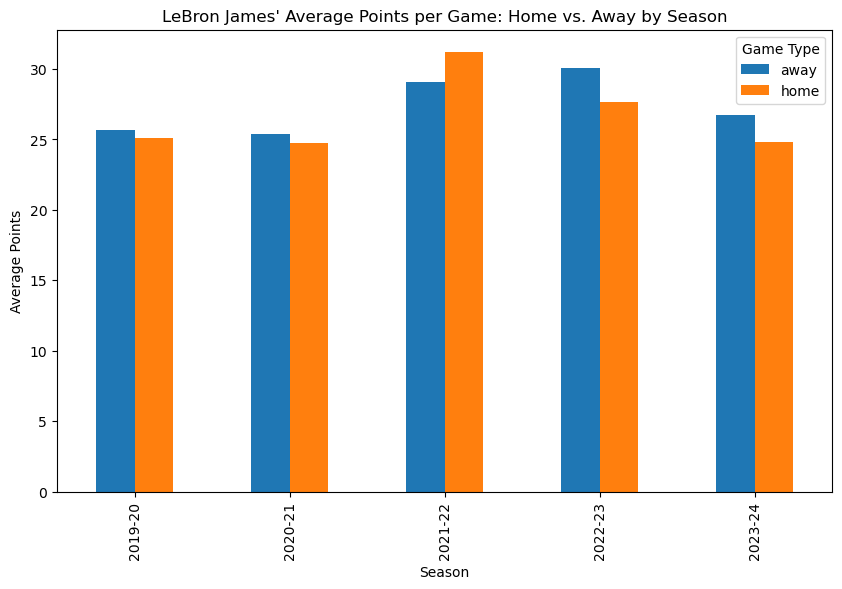

In [149]:
avg_points = date_season.groupby(['SEASON', 'GAME_TYPE'])['PTS'].mean().reset_index()

# Pivot the data for easier plotting
pivot_table = avg_points.pivot(index='SEASON', columns='GAME_TYPE', values='PTS')

# Plotting
pivot_table.plot(kind='bar', figsize=(10, 6))
plt.title("LeBron James' Average Points per Game: Home vs. Away by Season")
plt.xlabel('Season')
plt.ylabel('Average Points')
plt.legend(title='Game Type')
plt.show()

It does not seem like there is any useful pattern here, so well not investigate it as a feature.

In [150]:
# Clean up date_season dataframe
lebron_games_all_seasons = date_season[['Game_ID', 'MATCHUP', 'WL', 'PTS', 'DATE', 'SEASON_ID', 'OPP_TEAM_ID']].rename(columns = {'PTS': 'LeBron_PTS', 'DATE': 'GAME_DATE'})

# Clean up opp_team_data dataframe
opp_team_data = opp_team_data.rename(columns = {'TEAM_ID': 'OPP_TEAM_ID'})


In [151]:
# Merge date_season and opposing_team_data to find the defense data for the teams accumulated up to till the game they played against the LeBron


opp_defense_data = pd.merge(lebron_games_all_seasons, opp_team_data, on = ['GAME_DATE', 'OPP_TEAM_ID'], how = 'left').rename(columns = {'GAME_ID': 'Game_ID'})
opp_defense_data = opp_defense_data[['Game_ID', 'GAME_DATE', 'SEASON_ID', 'OPP_TEAM_ID', 'TEAM_NAME', 'DEF_RATING', 'DEF_RATING_RANK']]

### Combining All Subsets into one main Dataset


In [566]:

dataframes = [lebron_rolling_averages_ppg,lebron_ppg_so_far,opp_defense_data,ad_status_factors, team_rolling_averages_ppg]
dataset = lebron_data[['Game_ID','PTS', 'SEASON_ID', 'GAME_DATE']]
dataset['Game_ID'] = dataset['Game_ID'].astype(int)
for subset in dataframes:
    try: 
        subset['Game_ID'] = subset['Game_ID'].astype(int)
        dataset = dataset.merge(subset.drop(columns=['SEASON_ID', 'GAME_DATE']), on='Game_ID', how='left')
    except Exception as e:
        if ('SEASON_ID' not in subset.columns) and ('GAME_DATE' in subset.columns):
            dataset = dataset.merge(subset.drop(columns=['GAME_DATE']), on='Game_ID', how='left')
        elif ('GAME_DATE' not in subset.columns) and ('SEASON_ID' in subset.columns):
            dataset = dataset.merge(subset.drop(columns=['SEASON_ID']), on='Game_ID', how='left')
        else: dataset = dataset.merge(subset, on='Game_ID', how='left')
        
    #dataset = dataset.merge(subset.drop(columns=['SEASON_ID', 'GAME_DATE']), on='Game_ID', how='left')



/var/folders/vr/7j3r04fd5sd0mn53h_jrc5q00000gn/T/ipykernel_90802/2768825196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Game_ID'] = dataset['Game_ID'].astype(int)


### Splitting into Training and Test
Recall that we can use MSE to appraise the goodness of our model. However, to simulate how our model would work on future games, we want to look at MSE that is computed on games not used in training the model. To do this, we will split the data into a training and test data set. To best simulate future data while still conseving information for the model, the test set will be from the most recent data points. So, I will make the second half of the 2023-2024 season be our testing dataset.

In [567]:


from sklearn.model_selection import train_test_split

date_of_game_to_split = pd.to_datetime('02/13/2024')
game_split_id = dataset[dataset['GAME_DATE'] ==date_of_game_to_split]['Game_ID'].values[0]

dataset_copy = dataset.copy()

# Remove extra columns
dataset = dataset.drop(columns = ['SEASON_ID','TEAM_NAME', 'OPP_TEAM_ID' ])

# Make sure sorted by game_date
dataset = dataset.sort_values(by = 'GAME_DATE').reset_index(drop = True)

# Remove NA's
dataset = dataset[~dataset['LeBron_PPG_last_5'].isna()].drop(columns = {'GAME_DATE'})

# Make sure categorical variable correctly encoded
dataset['AD_Yes'] = dataset['AD_Yes'].apply(lambda x: 1 if x else 0)

dataset = dataset.reset_index(drop = True)
# Training and Validation set for our model
game_split_id_index = dataset[dataset['Game_ID'] == game_split_id].index.tolist()[0]
train_and_val = dataset.loc[:game_split_id_index,]
train_set, test_set = train_test_split(train_and_val, test_size=0.2, random_state=42)

# Test set That will be used at end to evaluate model we chose
final_test_set = dataset.iloc[game_split_id_index:,]


## Model Implementation

In [569]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial


#data_set_game_ids = pd.concat([X['Game_ID'], X_test['Game_ID']])

# Make sure cateogorical variable is encoded numerically

X = train_set
X_test = test_set
X_full = train_and_val
X_final_test = final_test_set

y_full = X_full['PTS']
y = X['PTS']
y_test = X_test['PTS']
y_final_test = X_final_test['PTS']


# Isolating just predictors
X = X.loc[:, 'LeBron_PPG_last_5':]
X_full = X_full.loc[:, 'LeBron_PPG_last_5':]
X_test = (X_test.loc[:, 'LeBron_PPG_last_5':])
X_final_test = (X_final_test.loc[:, 'LeBron_PPG_last_5':])


model = NegativeBinomial(y, X)


# Print the summary of the model
#print(results.summary())


summary_df = pd.DataFrame({
    'Coefficient': results.params,
    'P-value': results.pvalues
})

print(summary_df)

                     Coefficient       P-value
LeBron_PPG_last_5      -0.002101  7.063766e-01
LeBron_PPG_so_far       0.025309  5.440139e-02
DEF_RATING              0.024876  6.268411e-17
DEF_RATING_RANK        -0.006348  1.727233e-02
AD_Yes                 -0.102566  5.890821e-02
AD_miss_streak          0.000502  8.816093e-01
Starters_PPG_last_5     0.001592  4.879075e-01
Bench_PPG_last_5        0.001374  5.559786e-01
alpha                   0.039937  8.636861e-08


In [571]:
dataset

,Game_ID,PTS,LeBron_PPG_last_5,LeBron_PPG_so_far,DEF_RATING,DEF_RATING_RANK,AD_Yes,AD_miss_streak,Starters_PPG_last_5,Bench_PPG_last_5
0,21900054,23,23.333333,23.333333,108.1,21,1,0,27.000000,30.333333
1,21900074,39,25.000000,23.250000,108.1,21,1,0,23.666667,33.000000
2,21900088,21,27.333333,26.400000,105.6,15,1,0,26.666667,32.333333
3,21900100,30,27.666667,25.500000,108.7,18,1,0,26.000000,28.333333
4,21900126,25,30.000000,26.142857,100.6,5,1,0,24.333333,35.333333
...,...,...,...,...,...,...,...,...,...,...
274,22301103,25,26.333333,25.378788,118.8,28,1,0,44.000000,18.000000
275,22301127,24,29.333333,25.373134,112.0,7,1,2,49.666667,17.333333
276,22301155,33,24.000000,25.352941,114.6,16,0,0,47.000000,26.000000
277,22301177,37,27.333333,25.463768,113.6,12,1,0,54.000000,20.000000


Based off the summary, it seems like Defense rating, AD_status, LeBron_PPG_so_far, might be the most useful predictors. Let's Create a model using just those mentioned. 

In [572]:
def new_model_subset(dataSet, subset_list):
    X_full = dataSet.loc[0:game_split_id_index,]
    X, X_val = train_test_split(X_full, test_size=0.2, random_state=42)

    # Test set that will be used at end to evaluate model we chose
    X_final_test = dataSet.iloc[game_split_id_index:,]
    
    original_set_list = [X, X_val, X_full, X_final_test]
    modified_set_list =[]
    
    for x in original_set_list:
        x = x.loc[:, 'LeBron_PPG_last_5':]

        modified_set_list.append(x.iloc[:, subset_list])  # Select subset of columns
        
    print(modified_set_list[0].columns)
    return tuple(modified_set_list)

X2, X2_test, X2_full, X2_final_test = new_model_subset(dataset,[1,2,4, 5])


model_simple = NegativeBinomial(y, X2)
results = model.fit()
results_simple = model_simple.fit()

summary_df = pd.DataFrame({
    'Coefficient': results_simple.params,
    'P-value': results_simple.pvalues
})

print(summary_df)

Index(['LeBron_PPG_so_far', 'DEF_RATING', 'AD_Yes', 'AD_miss_streak'], dtype='object')
Optimization terminated successfully.
         Current function value: 3.420981
         Iterations: 24
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 3.442349
         Iterations: 16
         Function evaluations: 27
         Gradient evaluations: 27
                   Coefficient       P-value
LeBron_PPG_so_far     0.034991  3.610826e-04
DEF_RATING            0.022055  1.383406e-19
AD_Yes               -0.091537  7.838554e-02
AD_miss_streak        0.001868  5.878521e-01
alpha                 0.041462  1.002866e-07


Lets define a function to easily evaluate then "goodness" of our model

In [573]:
from sklearn.metrics import mean_squared_error, r2_score

def computeMSE(model, X_train, X_test, y_train, y_test):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    return [mean_squared_error(y_train, prediction_train),mean_squared_error(y_test, prediction_test)]

complex_mses = computeMSE(model = results,X_train =  X, X_test= X_test, y_train = y, y_test= y_test)

simple_mses = computeMSE(model = results_simple, X_train = X2, X_test= X2_test,y_train = y, y_test=y_test)




lebron_ppg_overall = lebron_data['PTS'].mean()
test_mse_average = ((y_test - lebron_ppg_overall)**2).mean()
train_mse_average= ((y - lebron_ppg_overall)**2).mean()


print(f"Training and Validation Mean Squared Error (MSE) using complex Model: {complex_mses}")


print(f"Training and Validation MSE using simple Model: {simple_mses}")


print(f"Training and Validation MSE using LeBron's Avergae Points 2019-2020 to 2022-2023 seasons: [{train_mse_average}, {test_mse_average}]")






Training and Validation Mean Squared Error (MSE) using complex Model: [55.779124461894796, 57.9400538457421]
Training and Validation MSE using simple Model: [58.083593671341866, 55.310298992433545]
Training and Validation MSE using LeBron's Avergae Points 2019-2020 to 2022-2023 seasons: [58.24168187600244, 55.938295831152985]


It looks like the complex model performes the best on validation and test, but the simple model is not far behind. Interesetingly, the validation error is lower for each of the models. LeBron's average points has a similar training MSE as the other two, but a higher validation error. 

The complex model has the smallest training MSE, but it does not do as well on the test data. According to the model summary, most of the predictors in the complex model had low statistical significance. Additionally, The simple model has higher training MSE than the complex one, but a slightly lower test MSE. So, it is likely the model fell into overfitting to the excess variables.

Ironically, the estimate with the smallest test MSE was simply LeBron's Average Points.

It is also important to note that these computed MSE's should be taken with a grain of salt. The test dataset is chosen from a single time period: the second half of the 2023-24 season, so it is not an absolute evaluation of model perforamnce. For example, in the test dataset, there are only a few days in which Davis misses games. This might make it so LeBron's Average Points performs better than it would usually. 

Let's visualize our predictions and how they differ from the actual values.

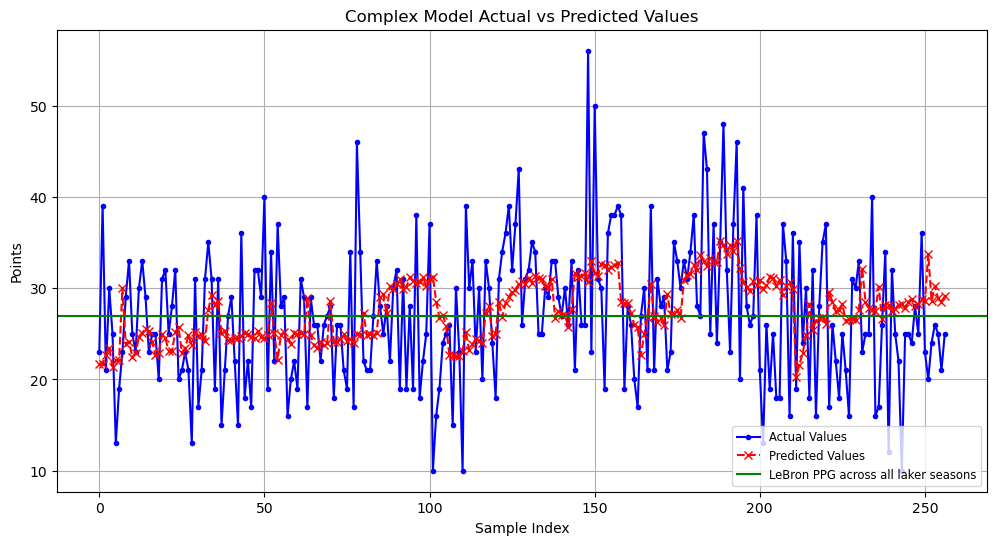

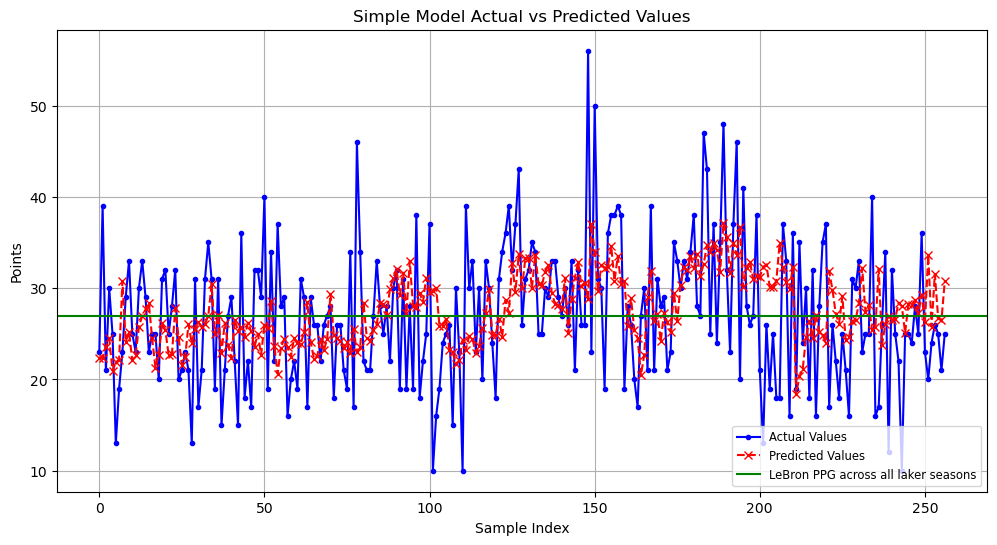

In [574]:
def model_graph(X, model, model_name):
    plt.figure(figsize=(12, 6))
    #rolling_averages = dataset_copy['LeBron_PPG_last_5']

    predicted_test = model.predict(X)
    # Plot the actual values
    plt.plot(y_full, label='Actual Values', color='blue', marker='.')

    # Plot the predicted values
    plt.plot(predicted_test, label='Predicted Values', color='red', linestyle='--', marker='x')
    #plt.plot(rolling_averages, label='LeBron PPG from previous 5 games', color='orange', linestyle='--', marker='.')

    # Plot the average of the actual values
    plt.axhline(y=lebron_ppg_overall, color='green', linestyle='-', label='LeBron PPG across all laker seasons')
    #plt.axhline(y=test_set['PTS'].mean(), color='purple', linestyle='-', label='LeBron Sample PPG from the test set')

    # Add labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Points')
    plt.title(f'{model_name} Actual vs Predicted Values')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()
    
model_graph(X_full, results, 'Complex Model')
model_graph(X2_full, results_simple, 'Simple Model')

From above it seems like the models do a solid job of capturing the general trend of LeBron's points, but it is not clear if it captures the actual variance on a game by game basis. Interestingly, it seems like the complex model has less volatility then the simple model. From just a glance it is hard to tell if this volatility is better or worse for the model.

*NOTE:* This is a mix of training and validation points so it is somewhat difficult to see the performance on the validation games specifically.

Let's take a look at how our model predictions behaved relative to our features from the training data. 

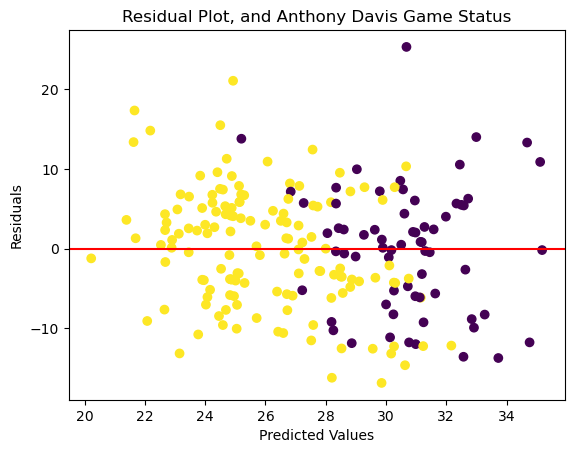

In [575]:
predicted_train = results.predict(X)
residuals_train = y - predicted_train
plt.scatter(predicted_train, residuals_train, c = X['AD_Yes'])
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot, and Anthony Davis Game Status')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

It looks like the residuals are consistently random across all of our predicted values.  There is noticeably two large clusters. The left is the predicted values when AD is playing, and the right is when AD is not playing. 

Let's revaluate some of our predictors and see if they have some nonlinear connections to LeBron's points. 


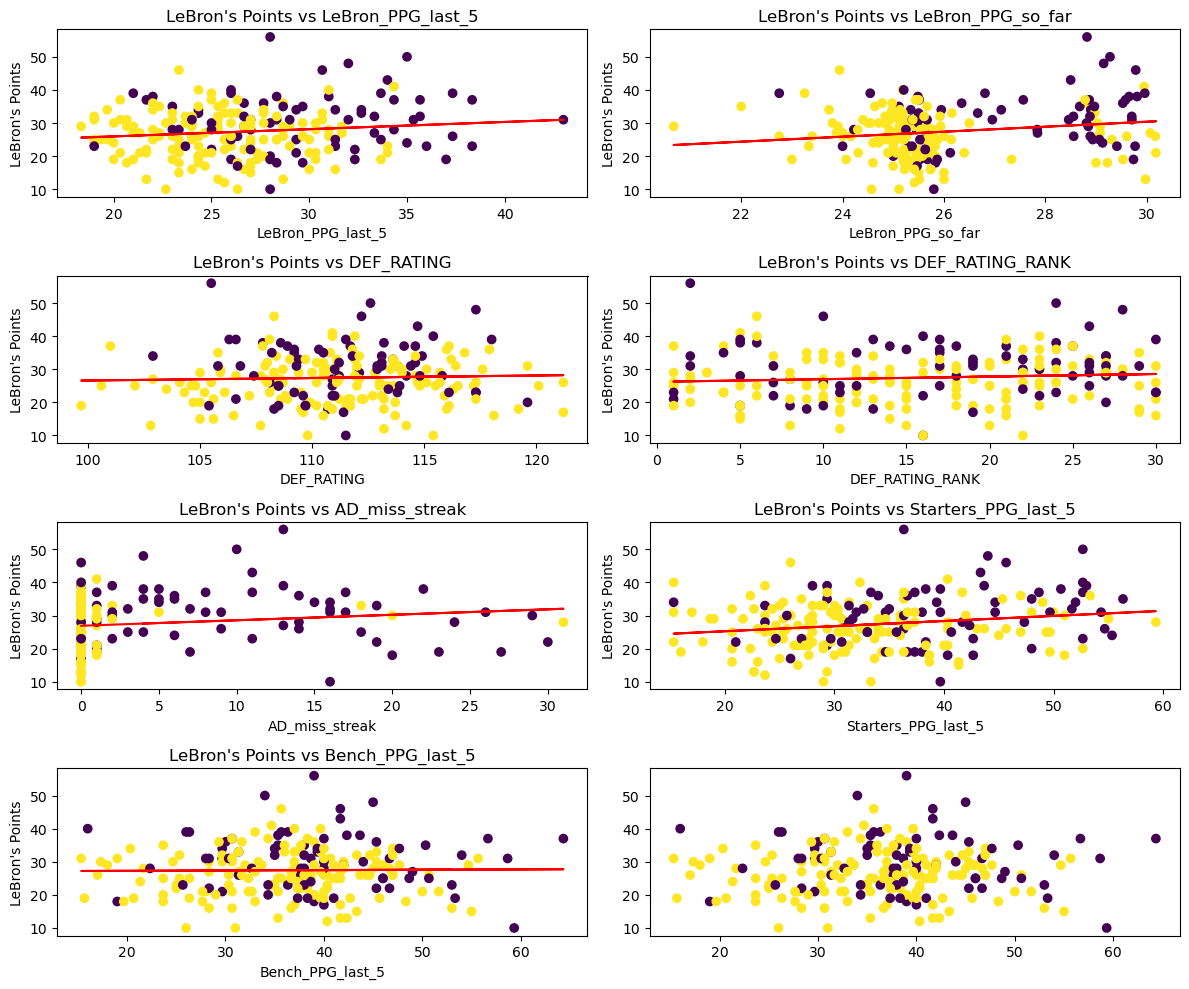

In [207]:
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
axs = axs.ravel()  

features = X.columns
features = features[features != 'AD_Yes']

for i, feature in enumerate(features):
    axs[i].scatter(X[feature], y.values, c=X['AD_Yes'], cmap='viridis')
    
    m, b = np.polyfit(X[feature], y.values, 1)
    axs[i].plot(X[feature], m * X[feature] + b, color='red')
    
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("LeBron's Points")
    axs[i].set_title(f"LeBron's Points vs {feature}")

# Add a colorbar to the last subplot
sc = axs[-1].scatter(X[features[-1]], y.values, c=X['AD_Yes'], cmap='viridis')
#fig.colorbar(sc, ax=axs, label='AD Game Status', pad=1)

plt.tight_layout()
plt.show()

It seems like there is some connection between LeBron's PPG and his recent PPG, but this correlation seems to mostly be present only for the games AD is missing. This could mean an interaction term with AD_Yes could be useful. 

The opposing Team's Defensive Rating and Rating Rank also seems to have a minimal linear effect on LeBron's Points. 

The computed correlation between LeBron's Points and AD's missed games in a row seems to be positive, but visually it looks more like a negative correlation. It seems like the games where AD has missed no games is bringing the correlation upward. To work around this, it would likely need to be turned intoa  categorical variable, where each category represents a different interval (e.g. 0-3 games, 4-6 games) This might not be effectove with the small sample size though.

It seems like Starters recent PPG does not provide much additional information, likely because it depends on  AD's presence. As for Bench recent PPG, there does not seem to be any clear relationship to LeBron's Points.



Lets try using a random forest to see if it can pick up any relationships the negative binomial model could not

In [576]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

rf_model_simple = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_simple.fit(X2, y)

RandomForestRegressor(random_state=42)

In [577]:
def rf_computeMetrics(model, X, y, X_val, y_val):
    y_pred = model.predict(X)
    y_pred_val  = model.predict(X_val)
    

    mse = mean_squared_error(y, y_pred)
    mse_val = mean_squared_error(y_val, y_pred_val)
    
    rmse = np.sqrt(mse)
    rmse_val = np.sqrt(mse_val)
    
    r2 = r2_score(y, y_pred)
    r2_val = r2_score(y_val, y_pred_val)

    print('Training and Test/Validation metrics, respectively')
    print(f"Mean Squared Error: {mse, mse_val}")
    print(f"Root Mean Squared Error: {rmse, rmse_val}")
    print(f"R-squared: {r2, r2_val}")
    print()

print('Metrics of Complex Model')
rf_computeMetrics(rf_model, X, y, X_test, y_test)

print('Metrics of Simple Model')
rf_computeMetrics(rf_model_simple, X2, y, X2_test, y_test)

Metrics of Complex Model
Training and Test/Validation metrics, respectively
Mean Squared Error: (8.161863902439025, 53.41114807692308)
Root Mean Squared Error: (2.8568976009719047, 7.308293102833457)
R-squared: (0.8593114550460086, 0.01618702724795651)

Metrics of Simple Model
Training and Test/Validation metrics, respectively
Mean Squared Error: (8.301830243902437, 55.07555000000001)
Root Mean Squared Error: (2.8812896841349427, 7.421290319075249)
R-squared: (0.8568988123998678, -0.014470621253406035)



- Compared to Negative Binomial, it seems like the random forest has a dramatically lower training mse for both models. 

- Interestingly, the validation MSE for the complex model performed worse in the random forest than in the negative binomial model, likely due to overfitting

In [578]:
def compute_Importance(model, X):
    feature_importances = model.feature_importances_
    features = X.columns

    # Create a DataFrame for the feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

print(f'Complex Model Importance: {compute_Importance(rf_model, X)}')

print(f'Simple Model Importance: {compute_Importance(rf_model_simple, X2)}')



Complex Model Importance:                Feature  Importance
1    LeBron_PPG_so_far    0.246667
6  Starters_PPG_last_5    0.159797
2           DEF_RATING    0.150936
7     Bench_PPG_last_5    0.116286
3      DEF_RATING_RANK    0.113172
0    LeBron_PPG_last_5    0.103478
5       AD_miss_streak    0.082908
4               AD_Yes    0.026756
Simple Model Importance:              Feature  Importance
0  LeBron_PPG_so_far    0.476641
1         DEF_RATING    0.368202
3     AD_miss_streak    0.116610
2             AD_Yes    0.038547


In the random forest, it seems like AD_Yes and AD_miss_streak are the least important variables. I think that this is because the other data capture the effects of AD's game participation, making it redundant to have a separate variable for them. 

Let's circle back to the Negative Binomial Regression model, and see how it performs  without AD_miss_streak and AD_Yes.

In [579]:
X3 = X.iloc[:, list(range(0, 4)) + [6,7]]


X3_test = X_test.iloc[:, list(range(0, 4)) + [6,7]]


model_3 = NegativeBinomial(y, X3)


results_3 = model_3.fit()

# Print the summary of the model
#print(results.summary())
print(results_3.summary())

Optimization terminated successfully.
         Current function value: 3.439971
         Iterations: 23
         Function evaluations: 39
         Gradient evaluations: 39
                     NegativeBinomial Regression Results                      
Dep. Variable:                    PTS   No. Observations:                  205
Model:               NegativeBinomial   Df Residuals:                      199
Method:                           MLE   Df Model:                            5
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:              -0.0008778
Time:                        19:46:57   Log-Likelihood:                -705.19
converged:                       True   LL-Null:                       -704.58
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
LeBron_PPG_last_5   

In [119]:
model_3_mses = computeMSE(model = results_3,X_train =  X3, X_test= X3_test, y_train = y, y_test= y_test)

print(f"New Model's Training and Test MSE's: {model_3_mses}")

New Model's Training and Test MSE's: [58.055579364218545, 50.52403618051412]


Removing AD_Yes seemed to help slightly with the test MSE, but it still performs worse than the simple model. 

## Using more advanced Statistics

Based on the performance of our first model, it seems like our predictors do not carry enough information to predict LeBron's points. The model was able to capture some time correlated information, but it was never able to capture the sources of variance on a given night. This is likely because of the vagueness or overgeneralization of our predictors. For example, we used the opponents team Defensive Rating as a predictor, which may be useful in predicting the Lakers points as a whole on a given night, but is likely less directly connected to specifically LeBron. A better alternative would be to look at the defense of each player on the enemy team and see how the strength of LeBron's most probable defender effects him. 

To produce more specific predictors, we'll need to utilize Advanced Boxscores.



In [215]:
from nba_api.stats.endpoints import BoxScoreAdvancedV3

# Gather advanced boxscores for all games LeBron has played in
def get_adv_boxscores_data_by_season(game_ids_by_season): 
    adv_boxscores_data_by_season = []

    for season_game_ids in game_ids_by_season:
        boxscores_data = pd.DataFrame()
        for game_id in season_game_ids:
            boxscore = BoxScoreAdvancedV3(game_id=game_id)
            boxscore_data = boxscore.get_data_frames()[0]
        
            # Combine Box Score with rest
            boxscores_data = pd.concat([boxscores_data, boxscore_data])
            print('Added Box Score')
            
        # Add season box scores to list 
        adv_boxscores_data_by_season.append(boxscores_data)
    return adv_boxscores_data_by_season
    print('Added Season Box Scores')

# For simplicity, I'll simply load presaved adv boxscores 
trad_path = os.path.join('..', 'data', 'advanced_boxscores.pkl')
with open(trad_path, 'rb') as file:
    adv_boxscores_data_by_season = pickle.load(file)

    
    
    



In [216]:
adv_boxscores = pd.DataFrame()
for boxscore in adv_boxscores_data_by_season:
    adv_boxscores = pd.concat([adv_boxscores, boxscore ])
    
opp_team_stats = adv_boxscores[adv_boxscores['teamName']!= 'Lakers'][['personId', 'gameId','position','defensiveRating','estimatedDefensiveRating', 'minutes']]

#### Extracting Defensive Rating of Opposing Team Starters

In [580]:

opp_team_stats = opp_team_stats[opp_team_stats['position'] != '']
position_def = pd.DataFrame()
position_def['gameId'] = opp_team_stats['gameId'].sort_values().unique()

# Categorize forwards by their minutes (how often on the floor)
forwards = opp_team_stats[opp_team_stats['position'] == 'F'].sort_values(by=['gameId', 'minutes'], ascending=[True, False]) # ordering them by most minutes
forwards['forward_type'] = forwards.groupby('gameId').cumcount().apply(lambda x: f'forward {x+1}')

position_def['forward1_def_rating'] = forwards[forwards['forward_type'] == 'forward 1']['defensiveRating'].reset_index(drop = True)
position_def['forward2_def_rating'] = forwards[forwards['forward_type'] == 'forward 2']['defensiveRating'].reset_index(drop = True)

# Categorize guards by their minutes (how often on the floor)
guards = opp_team_stats[opp_team_stats['position'] == 'G'].sort_values(by=['gameId', 'minutes'], ascending=[True, False]) # ordering them by most minutes
guards['guard_type'] = guards.groupby('gameId').cumcount().apply(lambda x: f'guard {x+1}')

position_def['guard1_def_rating'] = guards[guards['guard_type'] == 'guard 1']['defensiveRating'].reset_index(drop = True)
position_def['guard2_def_rating'] = guards[guards['guard_type'] == 'guard 2']['defensiveRating'].reset_index(drop = True)


centers = opp_team_stats[opp_team_stats['position'] == 'C'].sort_values(by=['gameId', 'minutes'], ascending=[True, False])
position_def['center_def_rating'] = centers['defensiveRating'].reset_index(drop = True)
position_def = position_def.rename(columns = {'gameId':'Game_ID'})


In [581]:
# Add new Features to Dataset

position_def['Game_ID'] = position_def['Game_ID'].astype(int)
train_set2 = pd.merge(train_set, position_def, on = 'Game_ID', how = 'left')
test_set2 = pd.merge(test_set, position_def, on = 'Game_ID', how = 'left')
train_and_val2 = pd.merge(train_and_val, position_def, on = 'Game_ID', how = 'left')
final_test_set2 = pd.merge(final_test_set, position_def, on = 'Game_ID', how = 'left')
dataset2 = pd.merge(dataset, position_def, on = 'Game_ID', how = 'left')


#### Extracting Offensive Rating of Other Lakers Starters

In [582]:

def min_to_int(minutes):
    parts = minutes.split(':')

    mins = int(parts[0])
    seconds = int(parts[1])
    
    # Convert minutes to a fraction of an hour
    decimal= seconds / 60
    # Combine hours and decimal minutes
    decimal_time = mins + decimal
    
    return decimal_time
    
laker_stats = adv_boxscores[adv_boxscores['teamName']== 'Lakers'][['personId', 'gameId','position','offensiveRating', 'minutes']]
laker_stats = laker_stats [laker_stats['position'] != '']

laker_stats['minutes'] = laker_stats['minutes'].apply(min_to_int)

starter_stats = laker_stats[laker_stats['personId'] != lebron_id]


In [583]:

starter_off = pd.DataFrame()
starter_off['gameId'] = laker_stats['gameId'].sort_values().unique()

# Since LeBron is not always in a fixed role, we have to go through the tedious process of grouping the positions more generally
center_off = starter_stats[starter_stats['position'] == 'C'][['gameId','offensiveRating']].rename(columns = {'offensiveRating': 'center_off'})

# Categorize forwards by their minutes (how often on the floor)
forwards = starter_stats[starter_stats['position'] == 'F'].sort_values(by=['gameId', 'minutes'], ascending=[True, False]) # ordering them by most minutes
forwards['forward_type'] = forwards.groupby('gameId').cumcount().apply(lambda x: f'forward {x+1}')

forward1_off = forwards[forwards['forward_type'] == 'forward 1'][['gameId','offensiveRating']]
forward2_off = forwards[forwards['forward_type'] == 'forward 2'][['gameId', 'offensiveRating']]
forward_off = pd.merge(forward1_off, forward2_off, on = 'gameId', how = 'outer', suffixes=('_forward1', '_forward2'))

# There are games where LeBron is center, so on these games there is no non-LeBron center. grouping by outer make sure the avg is between the forwards. And when LeBron is a forward, it is the average of the other forward and the center
forward_center_off = pd.merge(forward_off, center_off, on = 'gameId', how = 'outer')
forward_center_off['forward_center_off_avg'] = forward_center_off[['offensiveRating_forward1', 'offensiveRating_forward2', 'center_off']].mean(axis=1)

# Categorize guards by their minutes (how often on the floor)
guards = starter_stats[starter_stats['position'] == 'G'].sort_values(by=['gameId', 'minutes'], ascending=[True, False]) # ordering them by most minutes
guards['guard_type'] = guards.groupby('gameId').cumcount().apply(lambda x: f'guard {x+1}')


guard1 = guards[guards['guard_type'] == 'guard 1'][['gameId','offensiveRating']]
guard2 = guards[guards['guard_type'] == 'guard 2'][['gameId','offensiveRating']]

# There are games where LeBron is guard, so on these games there is no guard2. grouping by outer make sure the avg is just guard1 offensive rating
guard_off = pd.merge(guard1, guard2,on = 'gameId', how =  'outer' , suffixes=('_guard1', '_guard2'))
guard_off['guard_off_avg'] = guard_off[['offensiveRating_guard1', 'offensiveRating_guard2']].mean(axis=1)

# Merge guard and forward-center avg off ratings 
starter_off = pd.merge(starter_off, forward_center_off, on = 'gameId', how = 'left')
starter_off = pd.merge(starter_off, guard_off, on = 'gameId', how = 'left')
starter_off = starter_off.rename(columns = {'gameId':'Game_ID'})[['Game_ID', 'guard_off_avg', 'forward_center_off_avg']]
starter_off


,Game_ID,guard_off_avg,forward_center_off_avg
0,0021900002,102.10,101.75
1,0021900025,91.90,79.55
2,0021900040,110.40,100.85
3,0021900054,103.40,104.25
4,0021900074,115.15,114.70
...,...,...,...
289,0022301155,123.90,123.45
290,0022301177,108.35,112.20
291,0022301195,131.80,126.50
292,0022301203,94.55,102.50


In [595]:
# Add new Features to dataset

starter_off['Game_ID'] = starter_off['Game_ID'].astype(int)
train_set2 = pd.merge(train_set2, starter_off, on = 'Game_ID', how = 'left')
test_set2 = pd.merge(test_set2, starter_off, on = 'Game_ID', how = 'left')
train_and_val2 = pd.merge(train_and_val2, starter_off, on = 'Game_ID', how = 'left')
final_test_set2 = pd.merge(final_test_set2, starter_off, on = 'Game_ID', how = 'left')
dataset2 = pd.merge(dataset2, starter_off, on = 'Game_ID', how = 'left')





,Game_ID,PTS,LeBron_PPG_last_5,LeBron_PPG_so_far,DEF_RATING,DEF_RATING_RANK,AD_Yes,AD_miss_streak,Starters_PPG_last_5,Bench_PPG_last_5,forward1_def_rating,forward2_def_rating,guard1_def_rating,guard2_def_rating,center_def_rating,guard_off_avg,forward_center_off_avg
0,21900054,23,23.333333,23.333333,108.1,21,1,0,27.000000,30.333333,103.2,100.0,93.2,85.2,103.8,103.40,104.25
1,21900074,39,25.000000,23.250000,108.1,21,1,0,23.666667,33.000000,112.8,113.6,112.5,117.0,101.8,115.15,114.70
2,21900088,21,27.333333,26.400000,105.6,15,1,0,26.666667,32.333333,112.2,109.0,112.3,100.0,103.2,109.65,104.15
3,21900100,30,27.666667,25.500000,108.7,18,1,0,26.000000,28.333333,123.1,110.2,123.3,116.9,126.9,99.55,104.20
4,21900126,25,30.000000,26.142857,100.6,5,1,0,24.333333,35.333333,101.3,98.7,90.0,102.2,119.2,105.00,122.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,22301103,25,26.333333,25.378788,118.8,28,1,0,44.000000,18.000000,117.4,108.2,128.6,133.8,100.0,114.05,128.05
275,22301127,24,29.333333,25.373134,112.0,7,1,2,49.666667,17.333333,98.3,119.0,95.1,116.2,101.4,108.10,98.60
276,22301155,33,24.000000,25.352941,114.6,16,0,0,47.000000,26.000000,117.6,116.7,125.0,114.7,116.7,123.90,123.45
277,22301177,37,27.333333,25.463768,113.6,12,1,0,54.000000,20.000000,111.8,114.1,117.3,109.1,114.7,108.35,112.20


### Final Model Comparisons

In [584]:
# New Model that uses all current predictors
X4 = train_set2
X4_test = test_set2
X4_full = train_and_val2
X4_final_test = final_test_set2

# Isolating just predictors
X4 = X4.loc[:, 'LeBron_PPG_last_5':]
X4_full = X4_full.loc[:, 'LeBron_PPG_last_5':]
X4_test = (X4_test.loc[:, 'LeBron_PPG_last_5':])
X4_final_test = (X4_final_test.loc[:, 'LeBron_PPG_last_5':])

In [604]:
rf_model_adv = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_adv.fit(X4, y)


rf_computeMetrics(model = rf_model_adv, X = X4, y = y, X_val= X4_test, y_val= y_test)

Training and Test/Validation metrics, respectively
Mean Squared Error: (7.445359024390244, 39.46356346153846)
Root Mean Squared Error: (2.7286185193958947, 6.282003140841181)
R-squared: (0.8716620688212513, 0.27309621525885563)



By including defensive and offensive ratings by position, we have reduced the validation mse down to 39.463. Let's now create multiple subsets to see if there are any superior subsetes

In [594]:
dataset2

,Game_ID,PTS,LeBron_PPG_last_5,LeBron_PPG_so_far,DEF_RATING,DEF_RATING_RANK,AD_Yes,AD_miss_streak,Starters_PPG_last_5,Bench_PPG_last_5,forward1_def_rating,forward2_def_rating,guard1_def_rating,guard2_def_rating,center_def_rating
0,21900054,23,23.333333,23.333333,108.1,21,1,0,27.000000,30.333333,103.2,100.0,93.2,85.2,103.8
1,21900074,39,25.000000,23.250000,108.1,21,1,0,23.666667,33.000000,112.8,113.6,112.5,117.0,101.8
2,21900088,21,27.333333,26.400000,105.6,15,1,0,26.666667,32.333333,112.2,109.0,112.3,100.0,103.2
3,21900100,30,27.666667,25.500000,108.7,18,1,0,26.000000,28.333333,123.1,110.2,123.3,116.9,126.9
4,21900126,25,30.000000,26.142857,100.6,5,1,0,24.333333,35.333333,101.3,98.7,90.0,102.2,119.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,22301103,25,26.333333,25.378788,118.8,28,1,0,44.000000,18.000000,117.4,108.2,128.6,133.8,100.0
275,22301127,24,29.333333,25.373134,112.0,7,1,2,49.666667,17.333333,98.3,119.0,95.1,116.2,101.4
276,22301155,33,24.000000,25.352941,114.6,16,0,0,47.000000,26.000000,117.6,116.7,125.0,114.7,116.7
277,22301177,37,27.333333,25.463768,113.6,12,1,0,54.000000,20.000000,111.8,114.1,117.3,109.1,114.7


In [596]:
# Model without ad factors and offensive ratings
subset = [0,1,2]
subset.extend([x for x in range(6,13)])

X5,X5_test, X5_full, X5_final_test =  new_model_subset(dataset2, subset)

# Model without offensive ratings
subset = [0,1,2,4,5]
subset.extend([x for x in range(6,13)])

X7,X7_test, X7_full, X7_final_test =  new_model_subset(dataset2, subset)

# Model without ad factors and defense ratings
subset = [0,1,2,6,7]
subset.extend([x for x in range(12,14)])

X6,X6_test, X6_full, X6_final_test =  new_model_subset(dataset2, subset)

# Model without defense ratings
subset = [0,1,2,4,5,6,7]
subset.extend([x for x in range(12,14)])

X8,X8_test, X8_full, X8_final_test =  new_model_subset(dataset2, subset)




Index(['LeBron_PPG_last_5', 'LeBron_PPG_so_far', 'DEF_RATING',
       'Starters_PPG_last_5', 'Bench_PPG_last_5', 'forward1_def_rating',
       'forward2_def_rating', 'guard1_def_rating', 'guard2_def_rating',
       'center_def_rating'],
      dtype='object')
Index(['LeBron_PPG_last_5', 'LeBron_PPG_so_far', 'DEF_RATING', 'AD_Yes',
       'AD_miss_streak', 'Starters_PPG_last_5', 'Bench_PPG_last_5',
       'forward1_def_rating', 'forward2_def_rating', 'guard1_def_rating',
       'guard2_def_rating', 'center_def_rating'],
      dtype='object')
Index(['LeBron_PPG_last_5', 'LeBron_PPG_so_far', 'DEF_RATING',
       'Starters_PPG_last_5', 'Bench_PPG_last_5', 'center_def_rating',
       'guard_off_avg'],
      dtype='object')
Index(['LeBron_PPG_last_5', 'LeBron_PPG_so_far', 'DEF_RATING', 'AD_Yes',
       'AD_miss_streak', 'Starters_PPG_last_5', 'Bench_PPG_last_5',
       'center_def_rating', 'guard_off_avg'],
      dtype='object')


In [597]:
rf_model_adv2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_adv2.fit(X5, y)
print('Model without ad factors and offensive ratings')
rf_computeMetrics(model = rf_model_adv2, X = X5, y= y, X_val =X5_test,y_val= y_test)

rf_model_adv3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_adv3.fit(X6, y)

print('Model without ad factors and defense ratings')
rf_computeMetrics(model = rf_model_adv3, X = X6, y= y, X_val =X6_test,y_val= y_test)

rf_model_adv4 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_adv4.fit(X7, y)

print('Model without offense ratings')
rf_computeMetrics(model = rf_model_adv4, X = X7, y= y, X_val =X7_test,y_val= y_test)


rf_model_adv5 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_adv5.fit(X8, y)

print('Model without defense ratings')
rf_computeMetrics(model = rf_model_adv5, X = X8, y= y, X_val =X8_test,y_val= y_test)


Model without ad factors and offensive ratings
Training and Test/Validation metrics, respectively
Mean Squared Error: (7.722353658536585, 41.40335961538461)
Root Mean Squared Error: (2.778912315733727, 6.434544243020216)
R-squared: (0.8668874275746034, 0.237365910081744)

Model without ad factors and defense ratings
Training and Test/Validation metrics, respectively
Mean Squared Error: (8.193511219512196, 53.12936538461539)
Root Mean Squared Error: (2.862430998209773, 7.288989325319073)
R-squared: (0.8587659405601089, 0.021377356948228843)

Model without offense ratings
Training and Test/Validation metrics, respectively
Mean Squared Error: (7.2833853658536585, 40.442603846153844)
Root Mean Squared Error: (2.698774789761765, 6.359449964120627)
R-squared: (0.8744540583242344, 0.2550626648501364)

Model without defense ratings
Training and Test/Validation metrics, respectively
Mean Squared Error: (7.690848292682927, 49.480055769230766)
Root Mean Squared Error: (2.773237871637218, 7.034206

It seems like the model performs very similar to the full model without using offense ratings, while defense rating tends to be more important.

In [598]:

compute_Importance(X = X4, model =rf_model_adv)

,Feature,Importance
1,LeBron_PPG_so_far,0.146862
10,guard1_def_rating,0.124838
9,forward2_def_rating,0.106906
6,Starters_PPG_last_5,0.086617
8,forward1_def_rating,0.080891
11,guard2_def_rating,0.079373
12,center_def_rating,0.073866
2,DEF_RATING,0.062216
7,Bench_PPG_last_5,0.057019
5,AD_miss_streak,0.056974


Here we can see that the offensive rating scores are fairly low in importance.

In [599]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Create an SVM classifier with a linear kernel
svr_model = SVC(kernel='rbf')

# Train the classifier
svr_model.fit(X4, y)

svr_y4_pred = svr_model.predict(X4_test)

# Evaluate the model
mse = mean_squared_error(y_test, svr_y4_pred)
train_mse = mean_squared_error(y, svr_model.predict(X4))
r2 = r2_score(y_test, svr_y4_pred)

print(f'Validation Mean Squared Error: {mse}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'R^2 Score: {r2}')


Validation Mean Squared Error: 54.76923076923077
Training Mean Squared Error: 64.03414634146341
R^2 Score: -0.00882833787465942


It Seems like the support vector machine is worsening our performance, so we will stick to random forests.

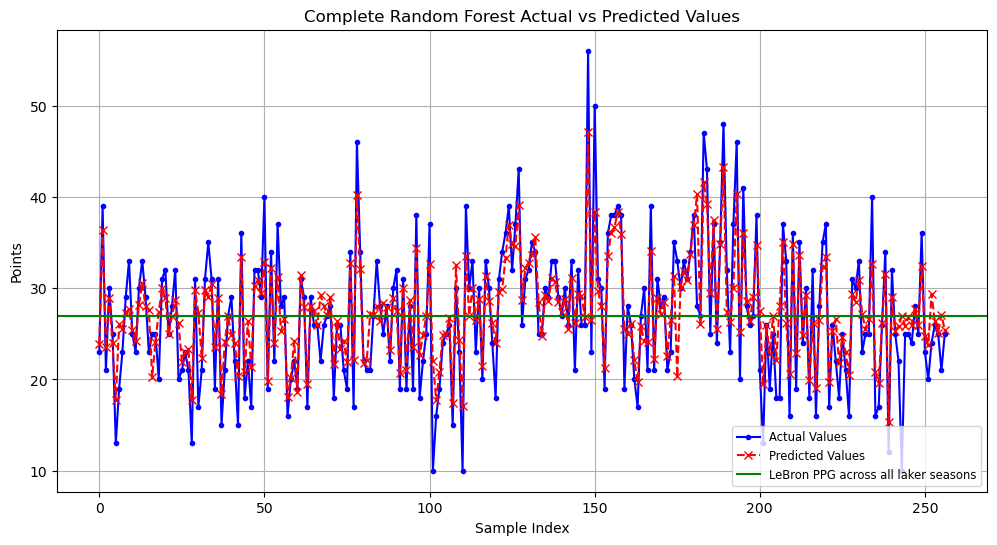

In [600]:
model_graph(X4_full, model = rf_model_adv, model_name = 'Complete Random Forest')

It Seems like the random forest is fitting very well to the training and validation set, but it might not be the best when generalizing to new test data considering just how well it is doing.

In [606]:
# Model without Rolling averages, Defensive rating
subset = [4]
subset.extend([x for x in range(8,15)])

X9,X9_test, X9_full, X9_final_test =  new_model_subset(dataset2, subset)


Index(['AD_Yes', 'forward1_def_rating', 'forward2_def_rating',
       'guard1_def_rating', 'guard2_def_rating', 'center_def_rating',
       'guard_off_avg', 'forward_center_off_avg'],
      dtype='object')


In [607]:
rf_model_adv6 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_adv6.fit(X9, y)

print('Model without Rolling Averages')
rf_computeMetrics(model = rf_model_adv6, X = X9, y= y, X_val =X9_test,y_val= y_test)


Model without Rolling Averages
Training and Test/Validation metrics, respectively
Mean Squared Error: (7.183431707317074, 42.26463846153846)
Root Mean Squared Error: (2.680192475796668, 6.501125937984778)
R-squared: (0.8761769901141333, 0.2215014822888285)



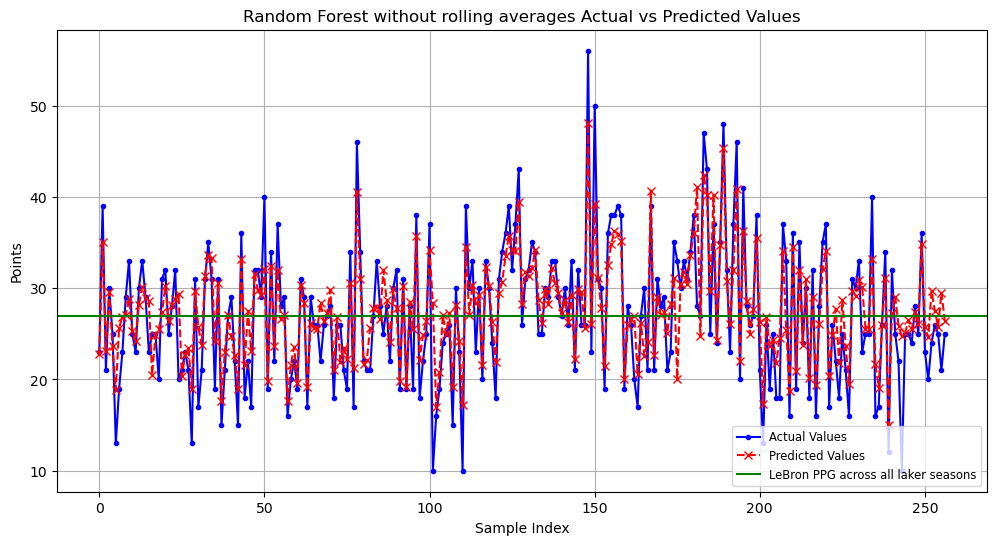

In [608]:
model_graph(X9_full, model = rf_model_adv6, model_name = 'Random Forest without rolling averages')

It seems the rolling averages had nothing to do with the early predictions, however, removing them overally lowered the validation MSE

It is now time to see how the following models will perform relative to our test set
- complete random forest
- random forest without rolling averages and overall defense ratings
- LeBron's average points 

In [610]:
print('Complete Random Forest')
rf_computeMetrics(rf_model_adv, X4, y, X4_final_test, y_final_test)

print('Partial Random Forest')
rf_computeMetrics(rf_model_adv6, X9, y, X9_final_test, y_final_test)

print('Partial Negative Binomial')
print(computeMSE(results_simple, X2, X2_final_test,y, y_final_test))

print('Complete Negative Binomial')
print(computeMSE(results, X, X_final_test, y, y_final_test))


lebron_ppg_overall = lebron_data['PTS'].mean()
test_mse_average = ((y_final_test - lebron_ppg_overall)**2).mean()
train_mse_average= ((y - lebron_ppg_overall)**2).mean()
print(f"Training and Final test MSE using LeBron's Avergae Points 2019-2020 to 2022-2023 seasons: [{train_mse_average}, {test_mse_average}]")





Complete Random Forest
Training and Test/Validation metrics, respectively
Mean Squared Error: (7.445359024390244, 35.68135217391305)
Root Mean Squared Error: (2.7286185193958947, 5.973386993483098)
R-squared: (0.8716620688212513, 0.12288869423791815)

Partial Random Forest
Training and Test/Validation metrics, respectively
Mean Squared Error: (7.183431707317074, 33.55699130434782)
Root Mean Squared Error: (2.680192475796668, 5.792839658090652)
R-squared: (0.8761769901141333, 0.17510927509293683)

Partial Negative Binomial
[58.083593671341866, 44.28074507309204]
Complete Negative Binomial
[55.779124461894796, 40.91106907440094]
Training and Final test MSE using LeBron's Avergae Points 2019-2020 to 2022-2023 seasons: [58.24168187600244, 40.890836044562754]


Overall, it Seems like the partial random forest model did slightly better against the final testing set than the complete models. This is likely because the complex models fell to overfitting, as seen from the graphs earlier. The complex negative binomial model actually did better than the partial.

## Conclusion

In this project I had the opportunity to work with several nba statistics to find a model that could accurately predict LeBron's points on a given day. 
- Through several iterations and analysis, I found the random forest to be the most effective model for the task. 
- Additionally, I was able to sucessfuly achieve my goal of finding a model that predicts better than simply using LeBron's PPG, which is impressive considering the amount of variance that takes place in an NBA game

### Model Improvements for the future

One of the biggest problems I ran into during this project was collecting the data. Due to nba_api's lack of consistency, it was not feasible to query more data than what was used for the project. In a perfect world, 
- I would have the data on every nba game, and with that data I would not need to tailor a dataset to one player specifically. 
- Though data from other players is not as rich as the data from a player themself, it would exponentially increase the sample size and allow for more flexibility and experimentation.
- With unlimited querying potential, I could also gain access to play by play data, which would be game changing for understanding a player's scoring potential based on the factors within a game. 
- With more models, it could also be useful to implement ensemble methods to help with reducing variance 
